In [13]:
import numpy as np
import scipy as sp
from scipy import io
import cv2 as cv 
import matplotlib.pyplot as plt
import pylab
import os # for reading all files in a folder
pylab.rcParams['figure.figsize'] = (6.0, 5.0)

In [14]:
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('jpeg') 

In [15]:
def computeLikelihood(image, template):
    likelihood = cv.matchTemplate(image[:,:,2], template, cv.TM_CCOEFF)

    # Padding for indexing
    pad_first = int(template.shape[0])
    pad_second = int(template.shape[1])
    pad_amounts = ((0, pad_first-1), (0, pad_second-1))
    likelihood = np.pad(likelihood, pad_amounts, 'constant')
    likelihood[likelihood<0] = 0 # to avoid negative weights 
    
    # smoothing
    kernel = np.ones((10,10),np.float32)/100
    smoothed = cv.filter2D(likelihood,-1,kernel) 
    return smoothed 

In [16]:
def condensation(corner):
    template = sp.io.loadmat(corner+'.mat')['pixelsTemplate']

    # Load all images in folder
    images = []
    iFrame = 0
    folder = 'Pattern01/'
    lst = os.listdir(folder)
    lst.sort()

    for frameNum in lst:
        images.append(cv.imread(folder+frameNum))
        iFrame += 1

    imgHeight, imgWidth, colors = images[0].shape
    numParticles = 2000;
    weight_of_samples = np.ones((numParticles,1))

    # normalize weights
    weight_of_samples = weight_of_samples / np.sum(weight_of_samples)

    # initialize samples
    samples_to_propagate = range(0, numParticles)

    numDims_w = 2;
    particles_old = np.random.rand(numParticles, numDims_w)
    particles_old[:,0] = particles_old[:,0] * imgHeight
    particles_old[:,1] = particles_old[:,1] * imgWidth

    # per-frame MAP estimate of w
    r = np.zeros((iFrame, numDims_w));

    for iTime in range(iFrame):
        # cumulative sum of weights
        if iTime == 0:
            cum_hist_of_weights = np.zeros(weight_of_samples.shape)
        for i in range(cum_hist_of_weights.shape[0]):
            if i == 0:
                cum_hist_of_weights[i] = 0
            else:
                cum_hist_of_weights[i] = cum_hist_of_weights[i-1] + weight_of_samples[i]


        # resample the old distribution at time t-1
        # select samples with higher posterior probability.
        samples_to_propagate = np.zeros(numParticles, dtype=np.int32)

        # select random thresholds
        some_threshes = np.random.rand(numParticles)


        # propagte samples above the threshold
        for sampNum in range(numParticles): 
            thresh = some_threshes[sampNum]
            for index in range (numParticles):
                if cum_hist_of_weights[index] > thresh:
                    break
            samples_to_propagate[sampNum] = index

        # compute the motion of particles in the next time step
        particles_new = np.zeros_like(particles_old)
        for particleNum in range(numParticles):
            # brownian motion with random noise
            particles_new[particleNum, :] = particles_old[samples_to_propagate[particleNum], :] + np.random.normal(0, 20, 2)
            
        # likelihood function
        likelihood = computeLikelihood(images[iTime], template)

        # process the next time state t 
        for particleNum in range(numParticles):

            # check the likelihood of each particle
            particle = particles_new[particleNum, :]
            inFrame = particle[0] >= 0.0 and  particle[0] <= imgHeight and particle[1] >= 0.0 and particle[1] <= imgWidth
            if inFrame:
                minX = particle[1]
                minY = particle[0]

                weight_of_samples[particleNum] = likelihood[int(minY), int(minX)]

            else:
                weight_of_samples[particleNum] = 0.0

        # normalize weights
        weight_of_samples = weight_of_samples / np.sum(weight_of_samples)
        
        # locate the particle with largest weight
        indices = np.argsort(weight_of_samples,0)
        bestScoringParticles = particles_new[np.squeeze(indices[-15:]), :]
        r[iTime,:] = bestScoringParticles[-1,1]+template.shape[1]/2,bestScoringParticles[-1,0]+template.shape[0]/2

        particles_old = particles_new

    return r

In [17]:
LLs = condensation( 'll' )
print("done")
LRs = condensation( 'lr' )
print("done")
ULs = condensation( 'ul' )
print("done")
URs = condensation( 'ur' )

done
done
done


In [18]:
# Load all images in folder
images = []
nFrame = 0
folder = 'Pattern01/'
lst = os.listdir(folder)
lst.sort()

for frameNum in lst:
    images.append(cv.imread(folder+frameNum))
    nFrame += 1

# Coordinates of the known target object (a dark square on a plane) in 3D:
XCart = np.array([[-50, -50,  50,  50],
          [50, -50, -50,  50],
            [0, 0, 0, 0]])

# These are some approximate intrinsics for this footage.
K = np.array([[640, 0, 320],
          [0, 512, 256],
            [0, 0, 1]])

# Define 3D points of wireframe object.
XWireFrameCart = np.array([[-50, -50,  50,  50, -50, -50,  50,  50],
          [50, -50, -50,  50, 50, -50, -50,  50],
            [0, 0, 0, 0, -100, -100, -100, -100, ]])

In [19]:
def projectiveCamera(K,T,XCart):
    XImCart = []

    # Convert Cartesian 3d points XCart to homogeneous coordinates XHom
    XHom = np.concatenate((XCart, np.ones((1,XCart.shape[1]))), axis=0)
    
    # Apply extrinsic matrix to XHom, to move to frame of reference of camera
    xCam = T @ XHom
    
    # Project points into normalized camera coordinates xCamHom (remove 4th row)
    xCamHom = xCam[0:3,:]
    
    # Move points to image coordinates xImHom by applying intrinsic matrix
    xImHom = K @ xCamHom
    
    # Convert points back to Cartesian coordinates xImCart
    XImCart = xImHom[0:2,:] / np.tile([xImHom[2,:]],(2,1))

    
    return XImCart


In [20]:
def solveAXEqualsZero(A):    
    u, s, vh = np.linalg.svd(A)
    
    # take first row since vh is V.T
    h = vh[-1]
    
    return h

In [21]:
def calcBestHomography(pts1Cart, pts2Cart):
    
    n_points = pts1Cart.shape[1]
    
    A = np.zeros([n_points * 2, 9])
    counter = 0

    for i in range(n_points):
        u = pts1Cart[:,i][0]
        v = pts1Cart[:,i][1]
        x = pts2Cart[:,i][0]
        y = pts2Cart[:,i][1]
        arr1 = np.array([0, 0, 0, -u, -v, -1, y*u, y*v, y])
        arr2 = np.array([u, v, 1, 0, 0, 0, -x*u, -x*v, -x])
        A[counter, :] = arr1
        A[counter + 1,:] = arr2
        counter += 2
            
    H = solveAXEqualsZero(A)
    H = H.reshape([3, 3])
    
    return H

In [22]:
def estimatePlanePose(XImCart,XCart,K):
    T = []
    

    # Convert Cartesian image points XImCart to homogeneous representation XImHom
    XImHom = np.concatenate((XImCart, np.ones((1,XImCart.shape[1]))), axis=0)
    
    # Convert image co-ordinates XImHom to normalized camera coordinates XCamHom    
    XCamHom = np.linalg.inv(K) @ XImHom
        
    # Estimate homography H mapping homogeneous (x,y) coordinates of positions
    # in real world to XCamHom (convert XCamHom to Cartesian, calculate the homography) -
    # use the routine you wrote for Practical 1B
    XCamCart = XCamHom[0:2,:] / np.tile([XCamHom[2,:]],(2,1))

    HEst = calcBestHomography(XCart, XCamCart)
              
    # Estimate first two columns of rotation matrix R from the first two
    # columns of H using the SVD. NOTE: You do not need to transpose v from linalg.svd    
    omega = HEst[:, 0:2]
    
    u, s, vh = np.linalg.svd(omega)
    I = np.array([[1.0, 0], [0, 1.0], [0, 0]])
    omega_hat = u @ I @ vh
    

    # Estimate the third column of the rotation matrix by taking the cross
    # product of the first two columns
    col_3 = np.cross(omega_hat[:, 0], omega_hat[:, 1]).reshape(3, 1)
        
    # Check that the determinant of the rotation matrix is positive - if not then multiply last column by -1.
    rot_mat = np.hstack((omega_hat, col_3))
    det = np.linalg.det(rot_mat)
    if det < 0:
        col_3 = col_3 * -1
    
    # Estimate the translation t by finding the appropriate scaling factor k
    # and applying it to the third colulmn of H
    k = 0
    for m in range(3):
        for n in range(2):
            k += omega[m, n] / omega_hat[m, n] / 6

    tau = HEst[:, 2].reshape(3, 1) / k
        
    # Check whether t_z is negative - if it is then multiply t by -1 and
    # the first two columns of R by -1.
    if tau[-1] < 0:
        tau = tau * -1
        omega_hat = omega_hat * -1
        
            
    # Assemble transformation into matrix form
    T = np.hstack((omega_hat, col_3, tau))
    T = np.vstack((T, np.array([0,0,0,1])))
    
    return T 

1


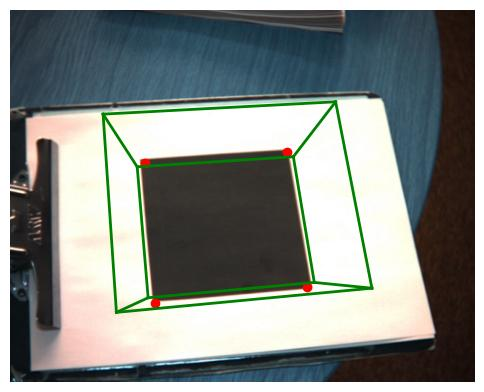

2


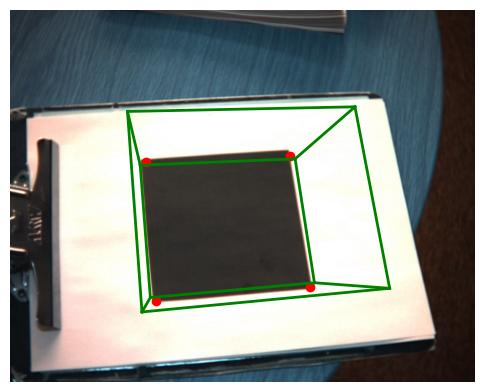

3


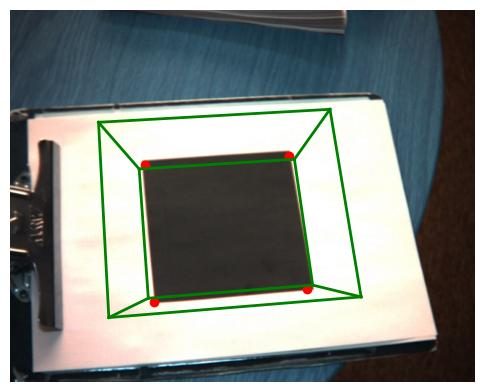

4


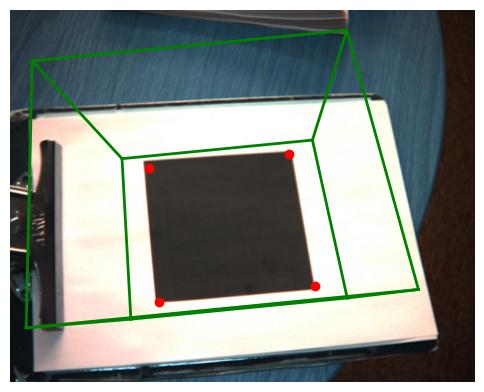

5


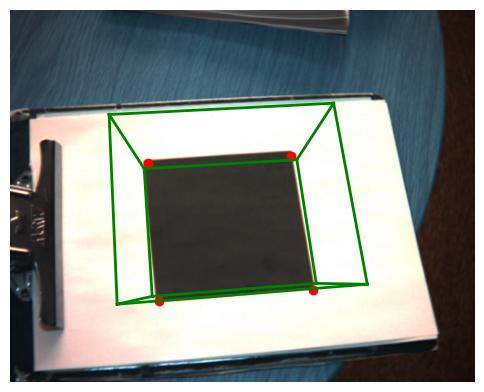

6


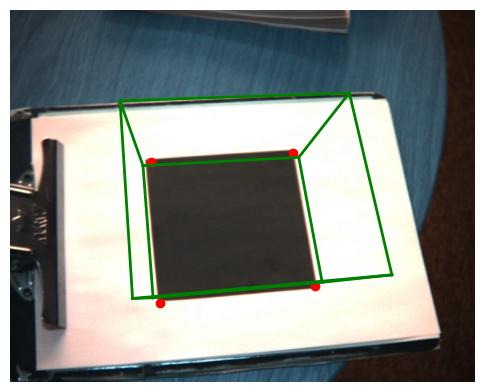

7


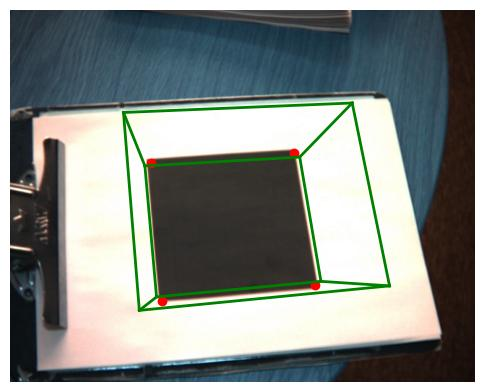

8


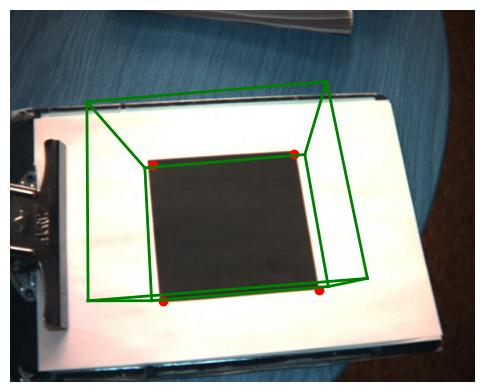

9


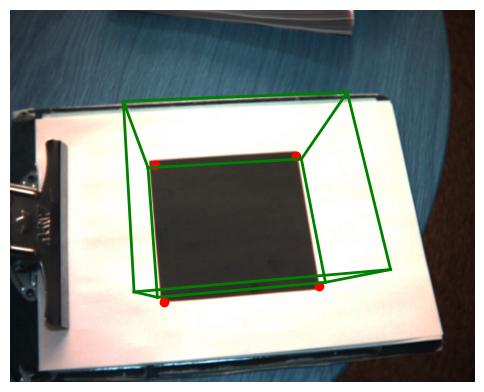

10


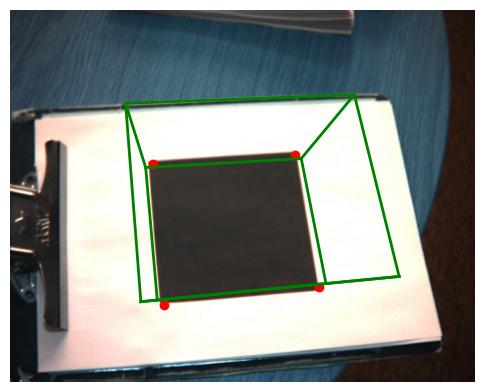

11


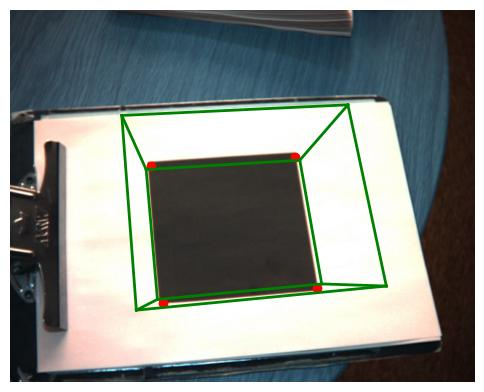

12


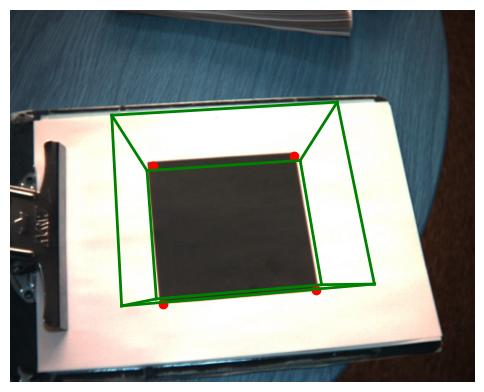

13


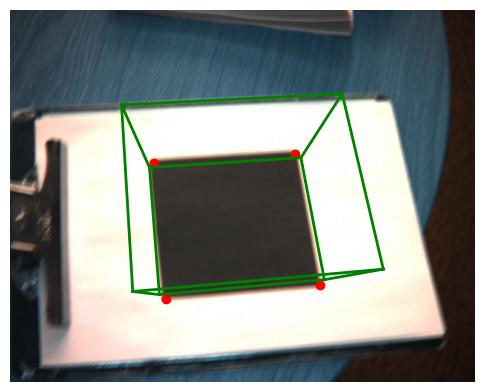

14


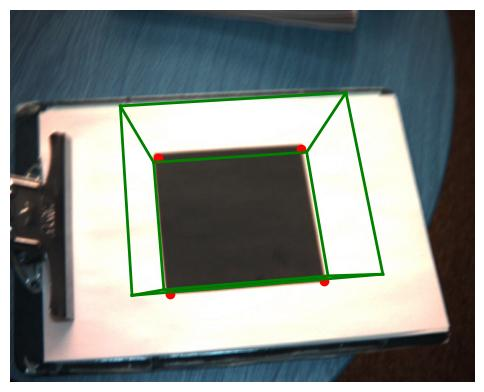

15


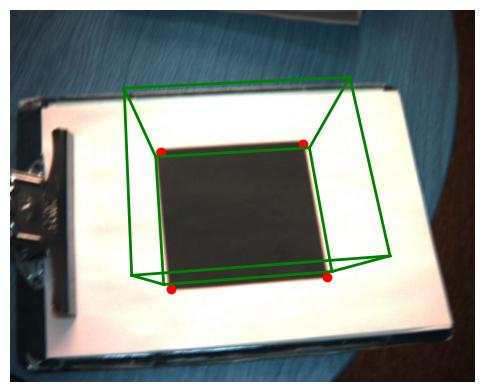

16


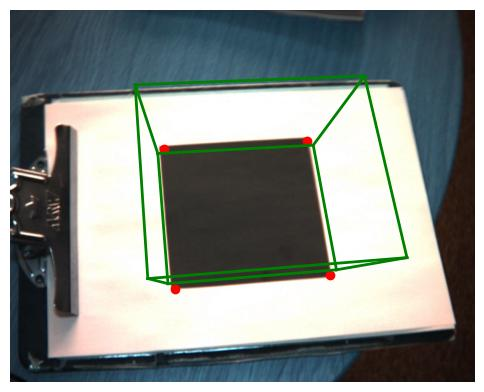

17


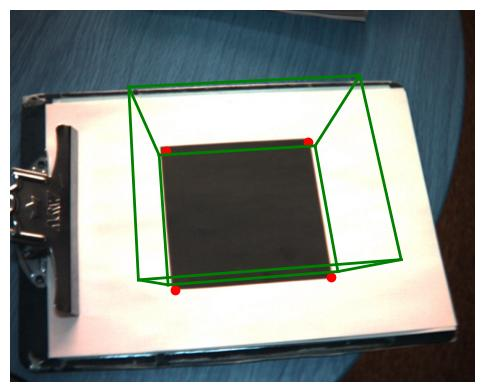

18


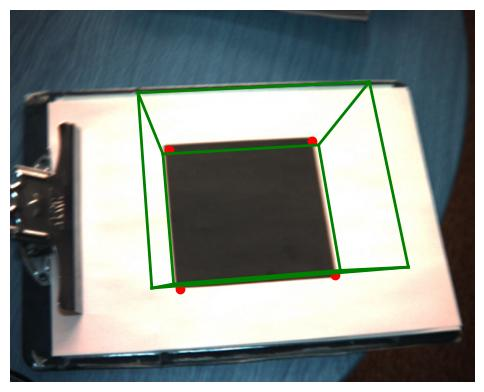

19


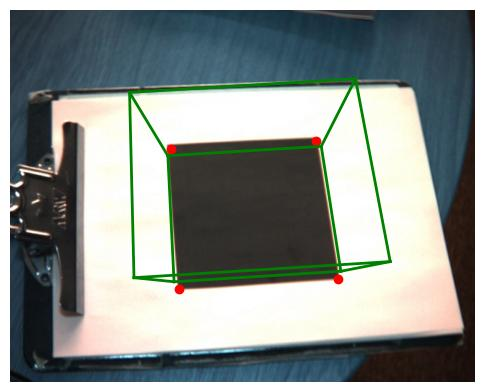

20


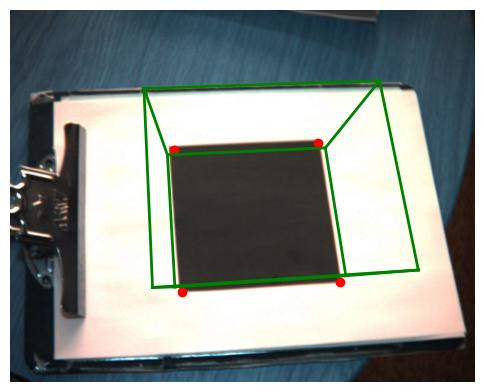

21


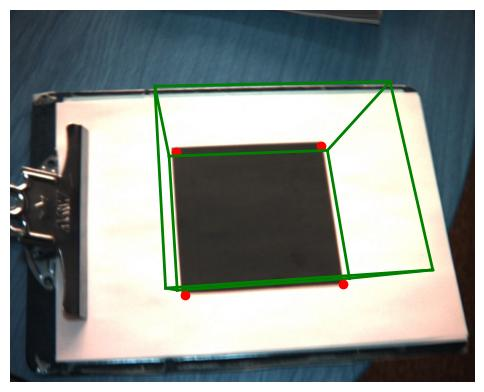

22


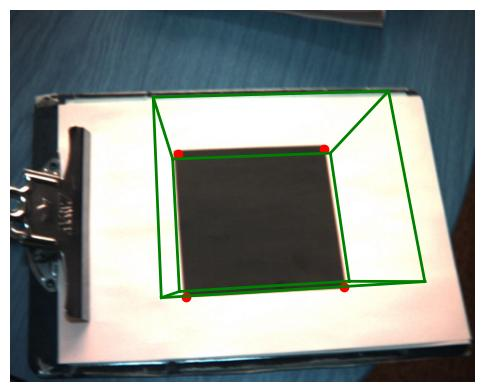

23


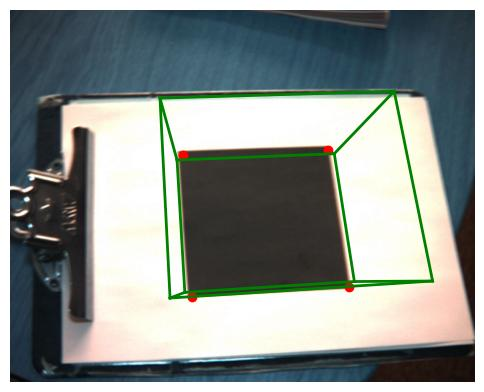

24


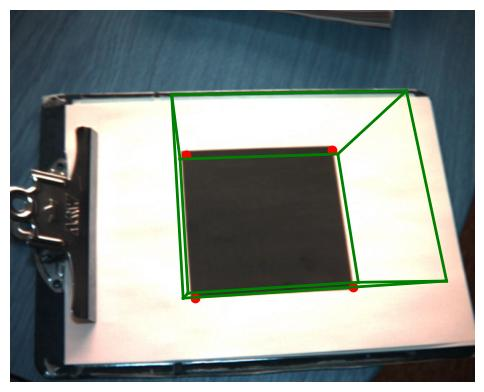

25


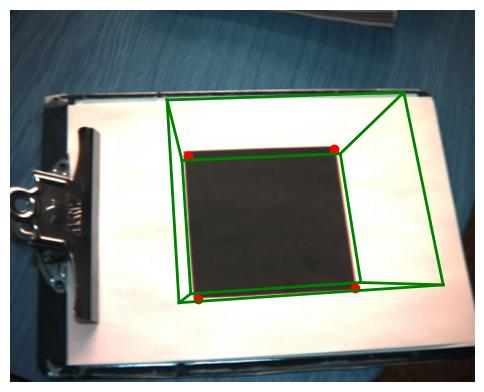

26


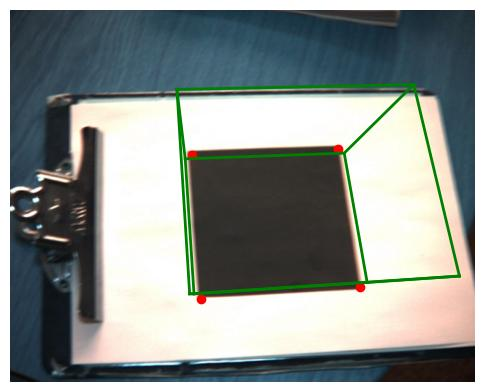

27


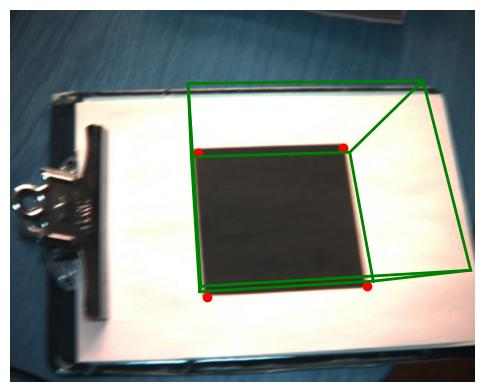

28


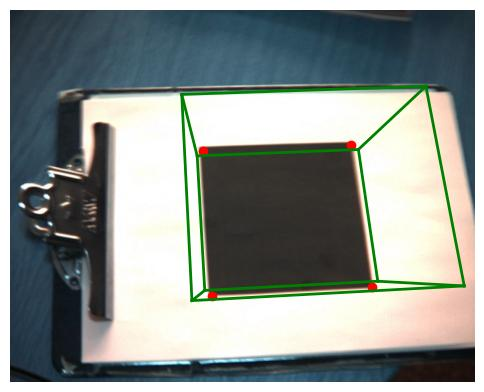

29


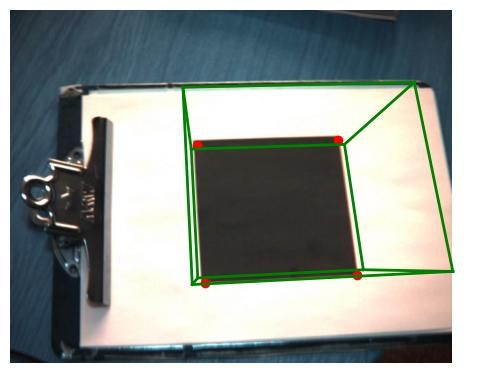

30


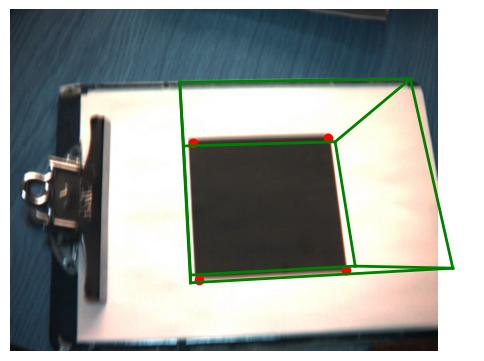

31


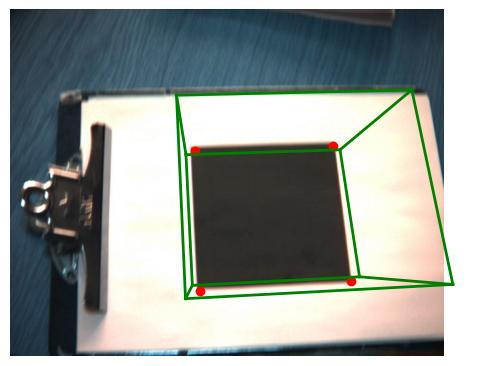

32


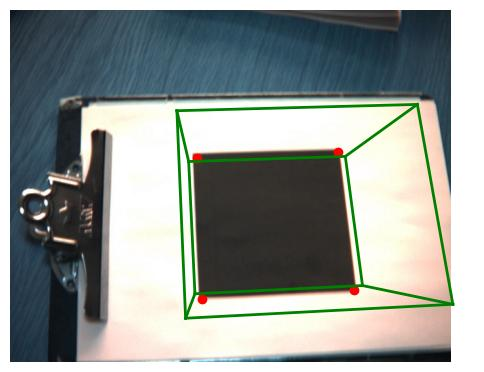

33


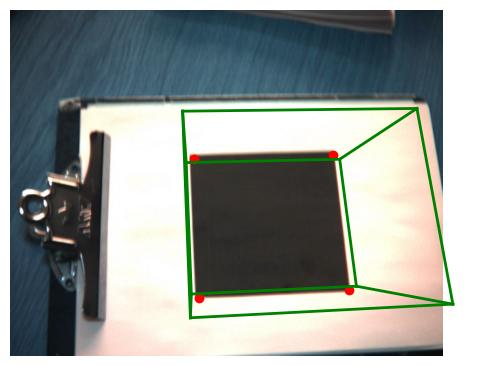

34


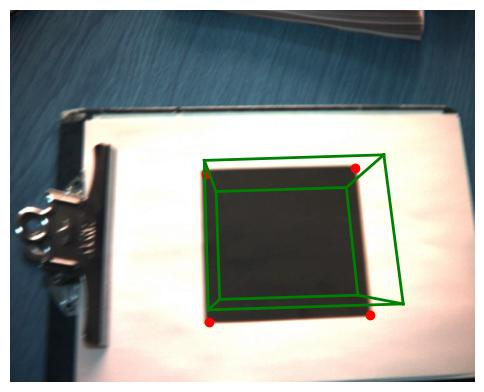

35


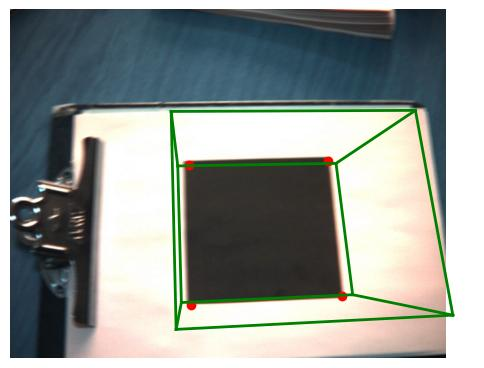

36


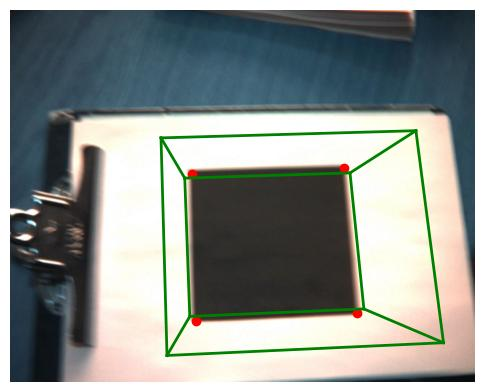

37


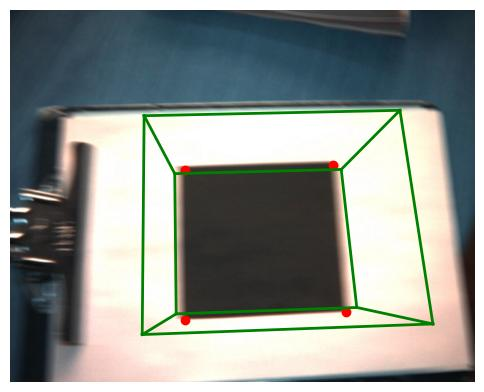

38


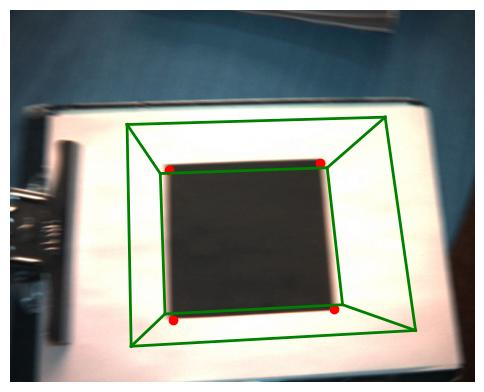

39


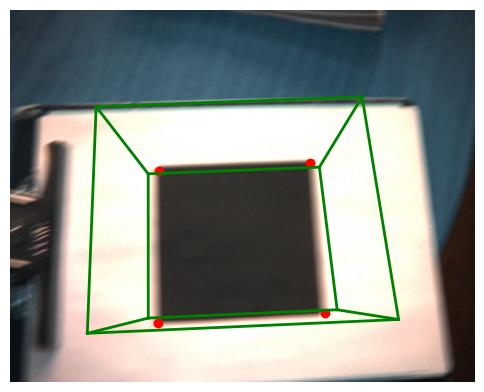

40


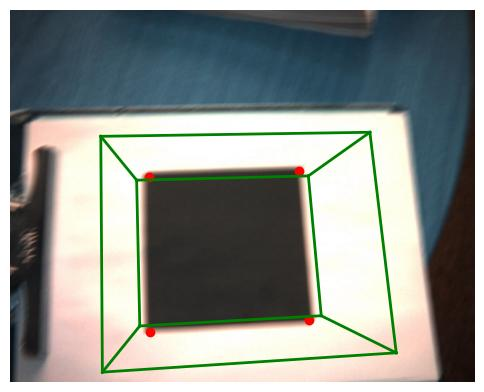

41


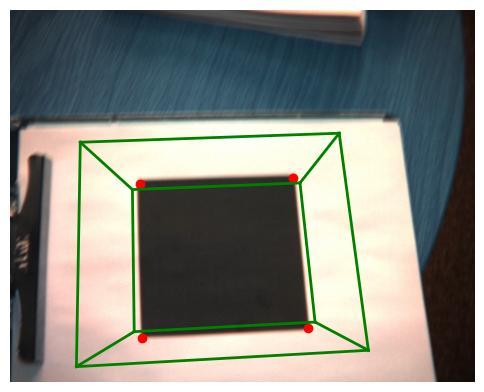

42


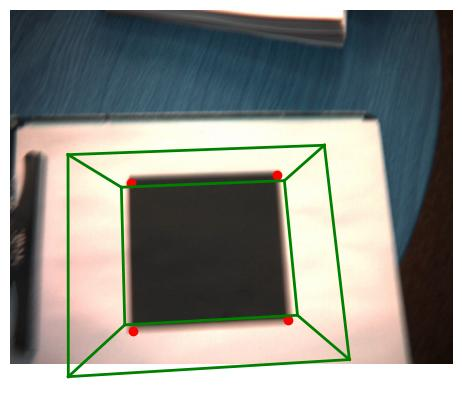

43


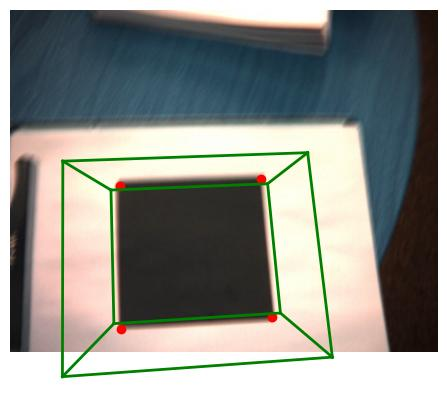

44


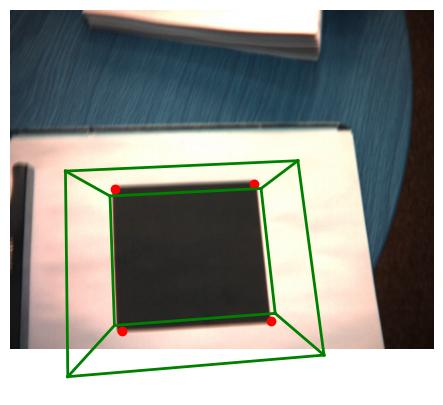

45


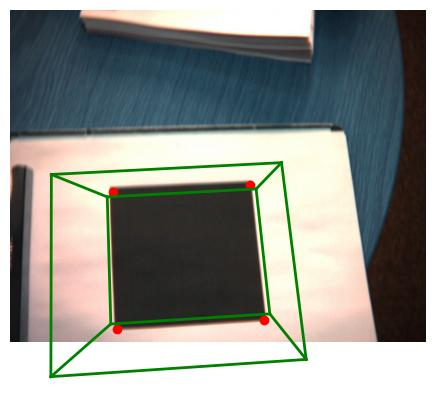

46


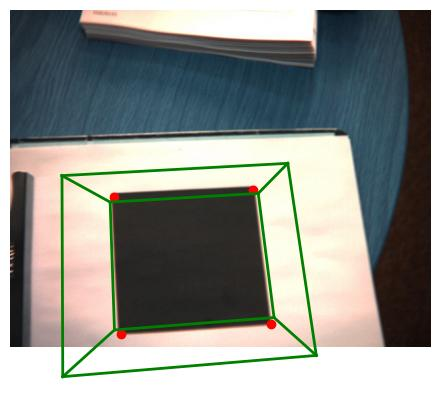

47


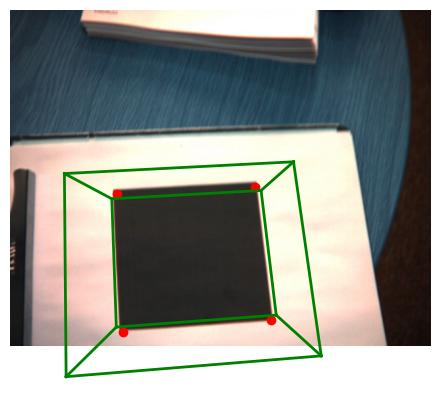

48


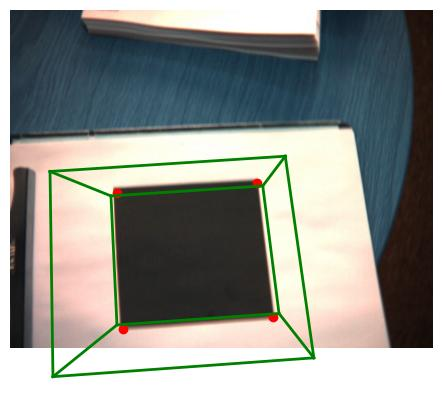

49


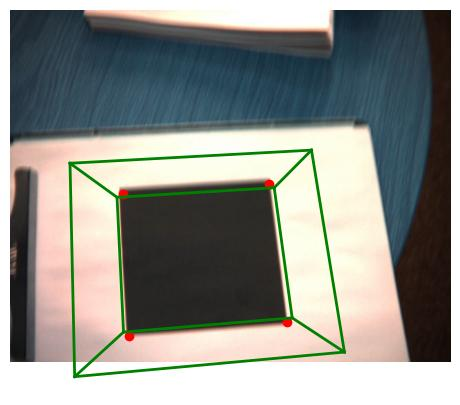

50


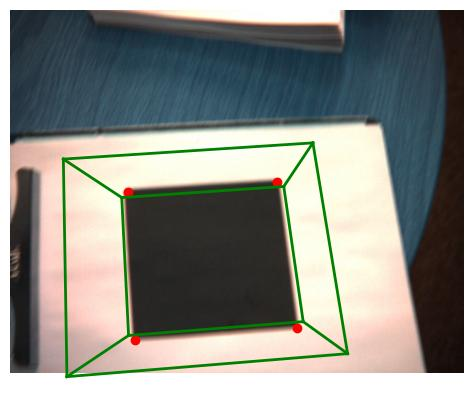

51


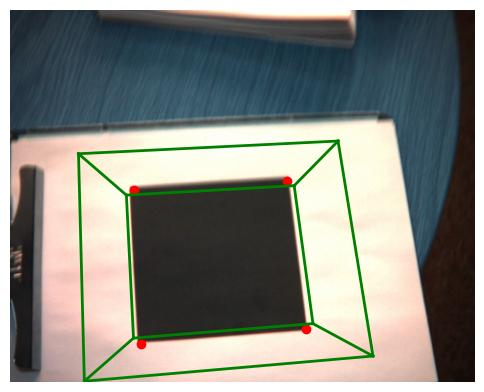

52


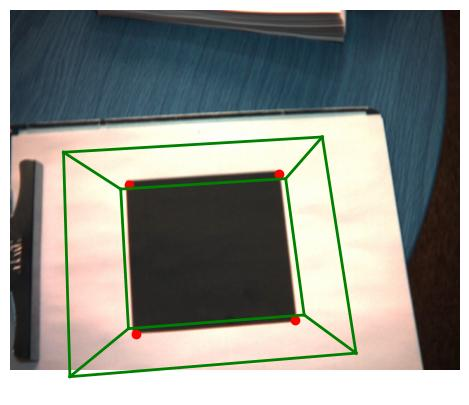

53


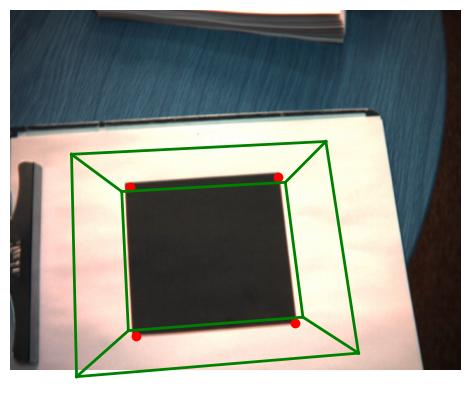

54


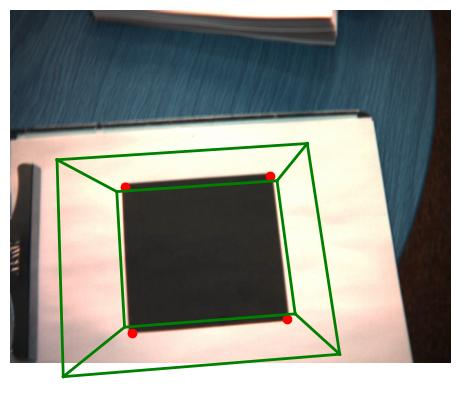

55


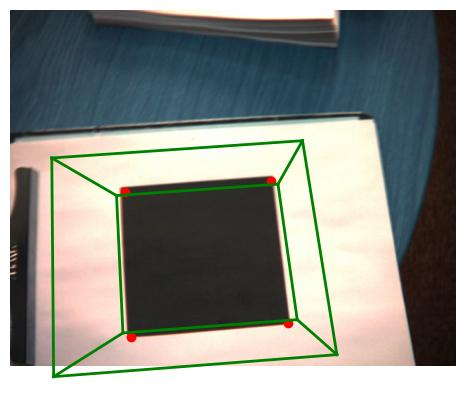

56


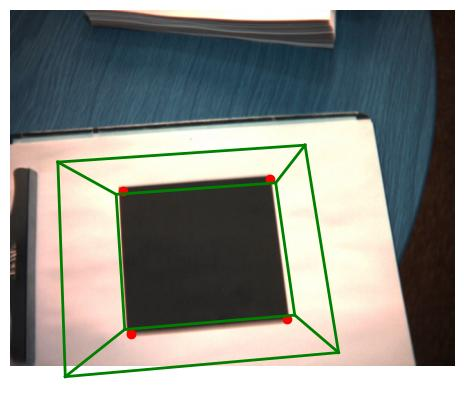

57


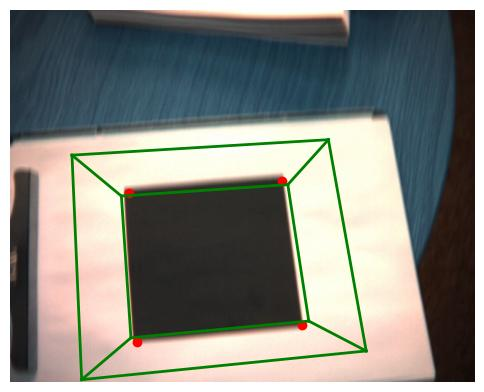

58


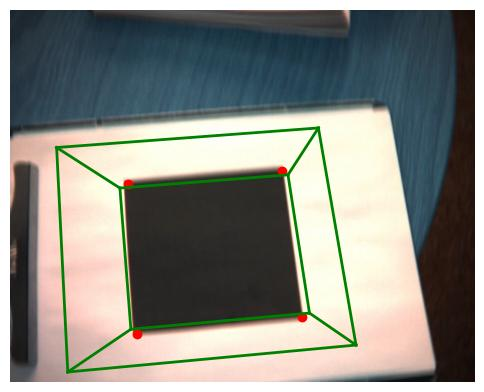

59


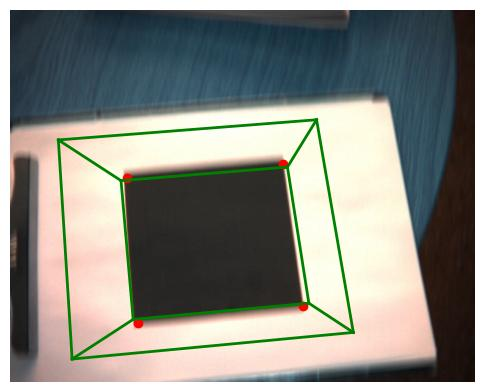

60


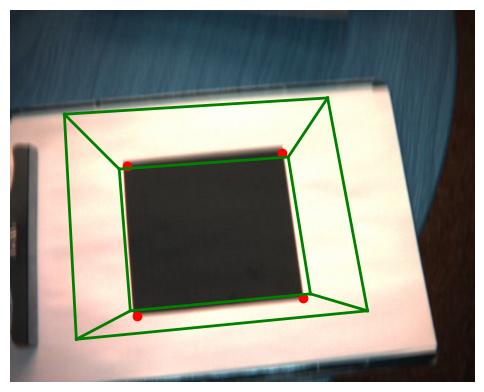

61


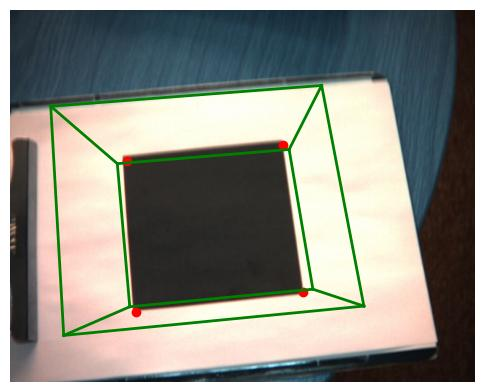

62


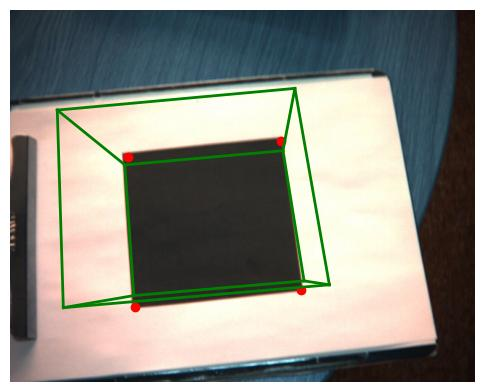

63


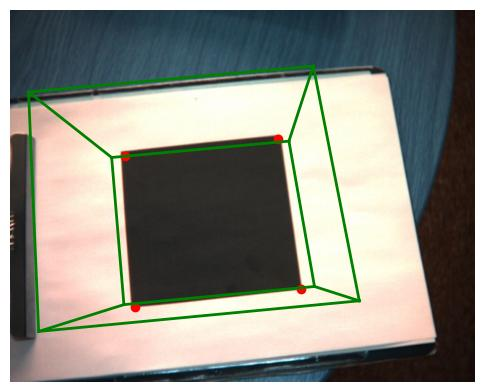

64


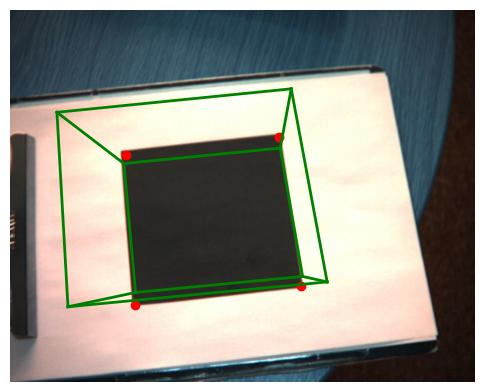

65


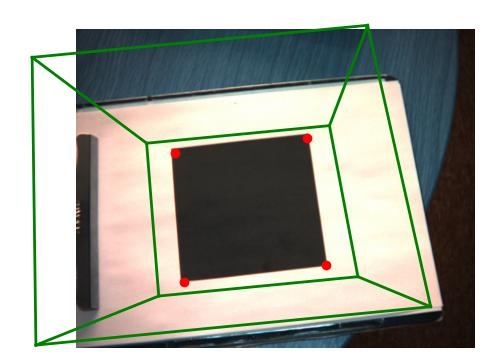

66


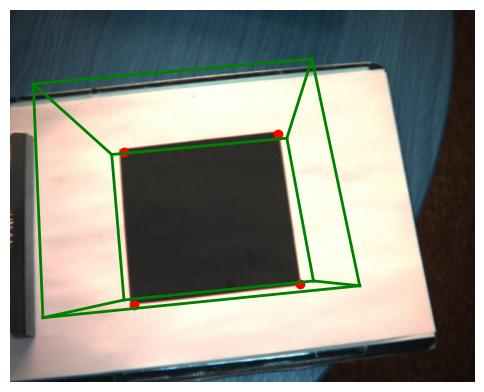

67


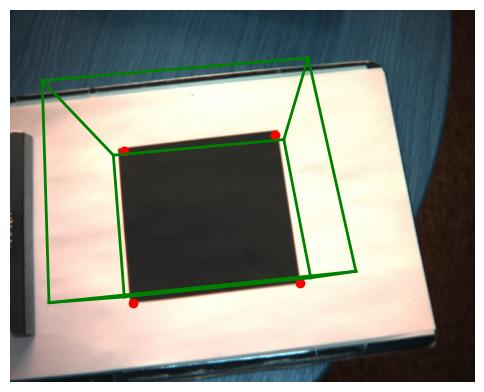

68


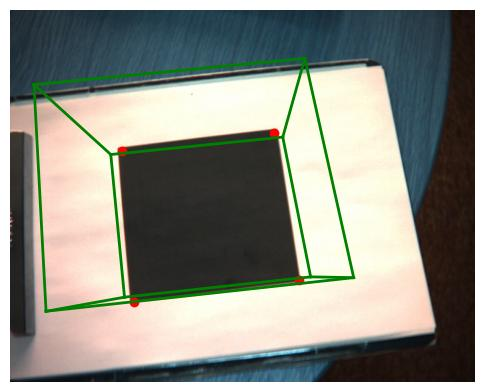

69


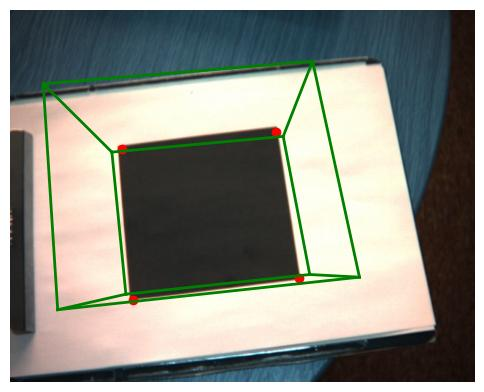

70


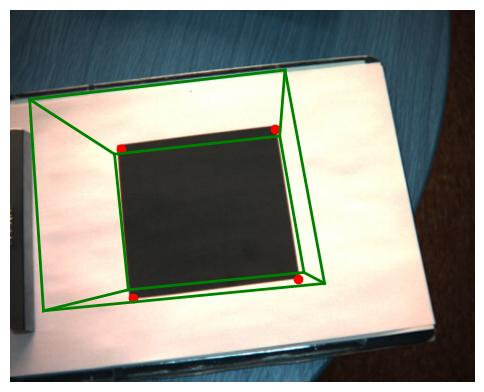

71


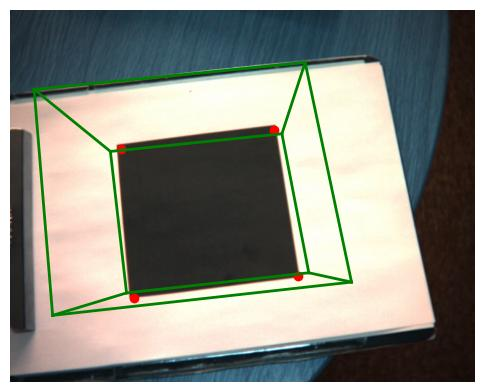

72


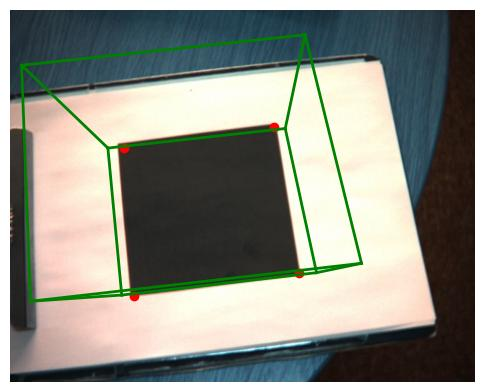

73


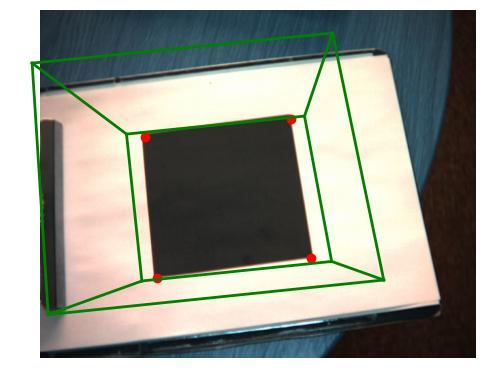

74


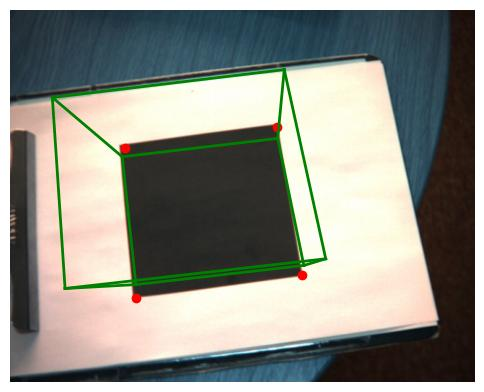

75


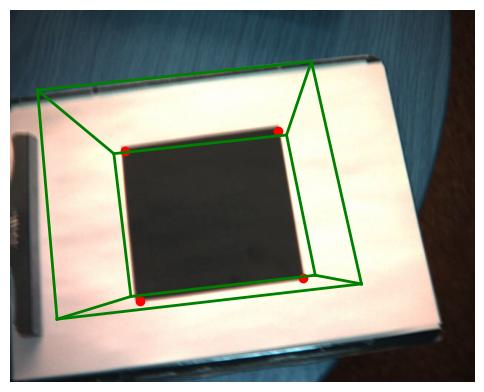

76


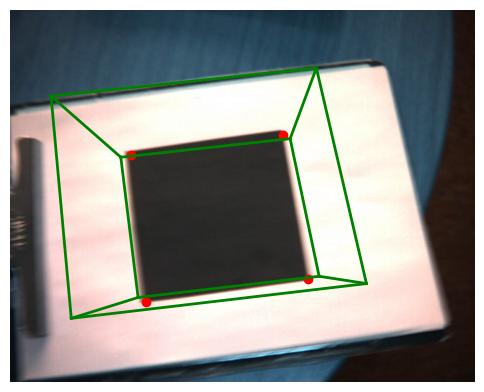

77


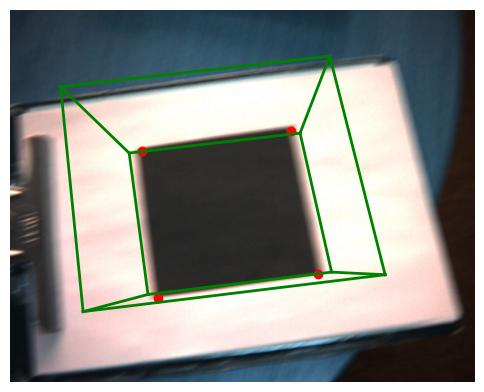

78


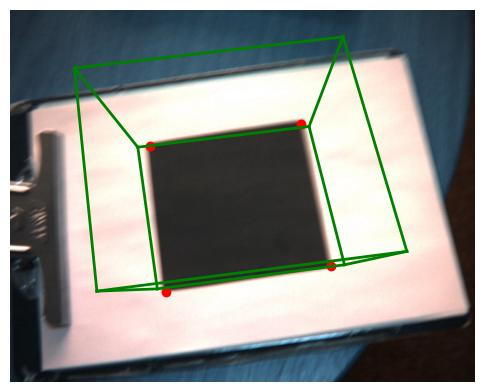

79


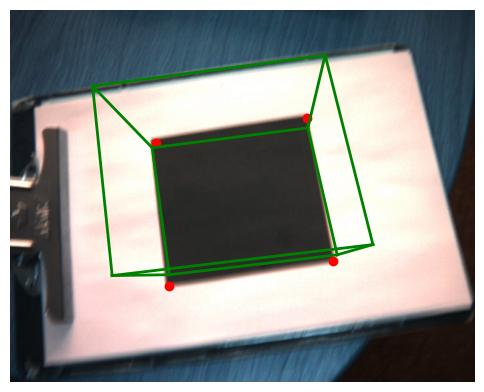

80


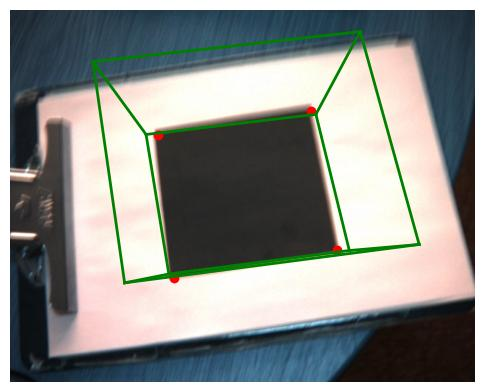

81


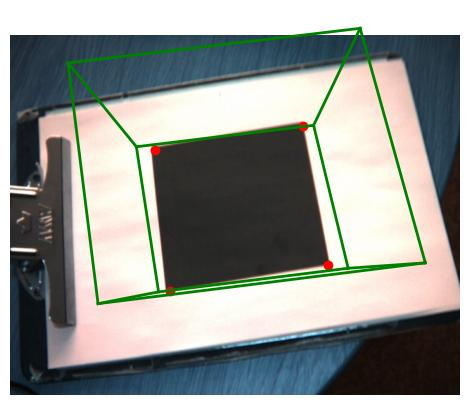

82


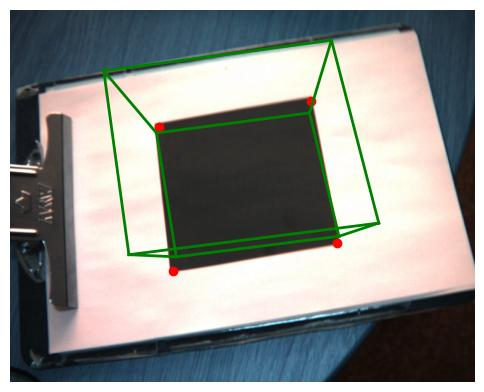

83


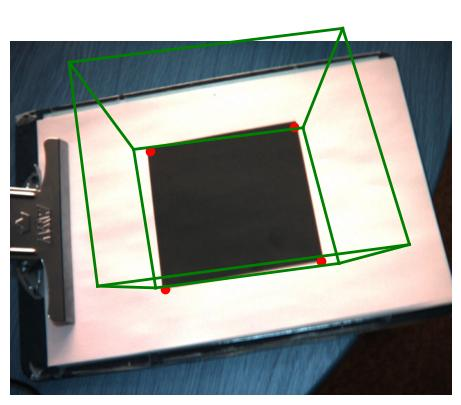

84


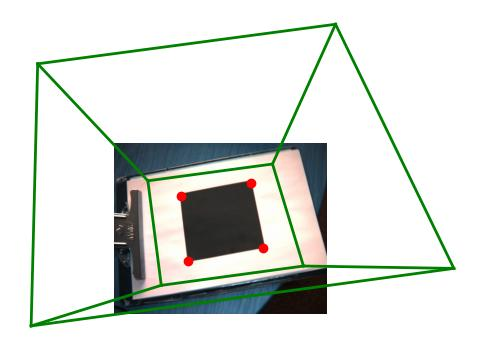

85


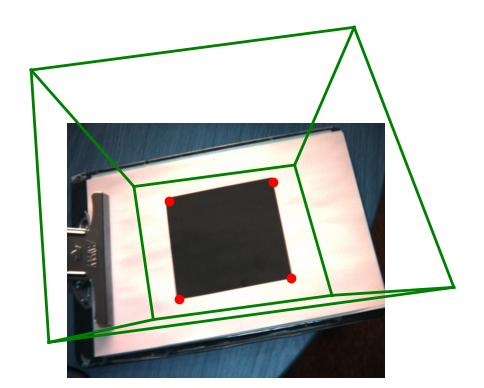

86


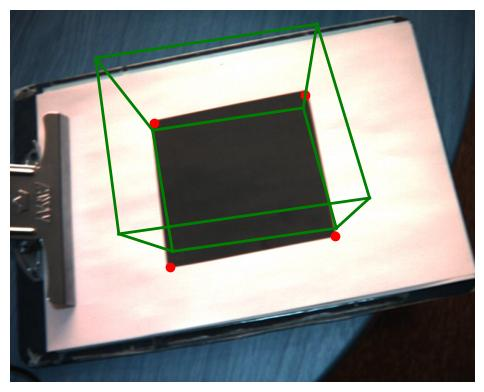

87


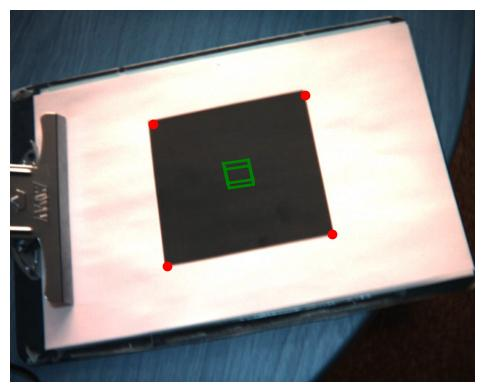

88


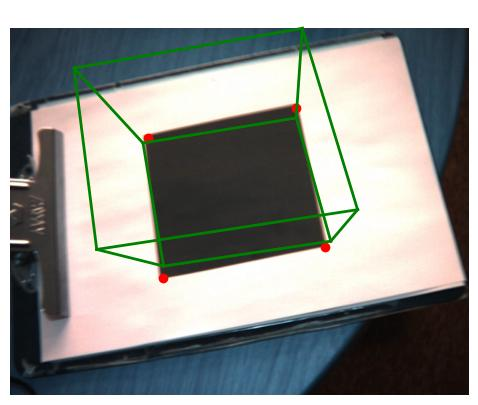

89


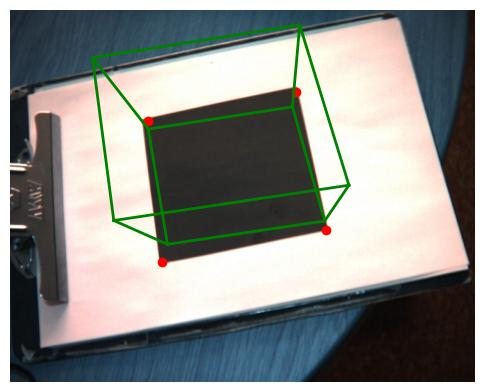

90


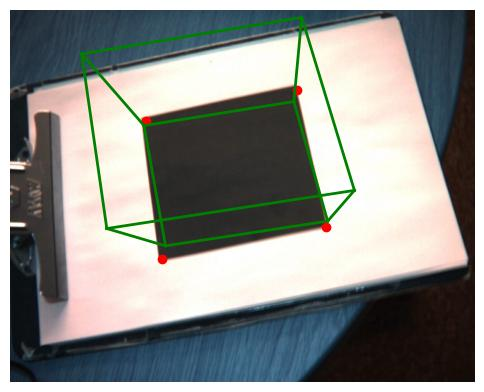

91


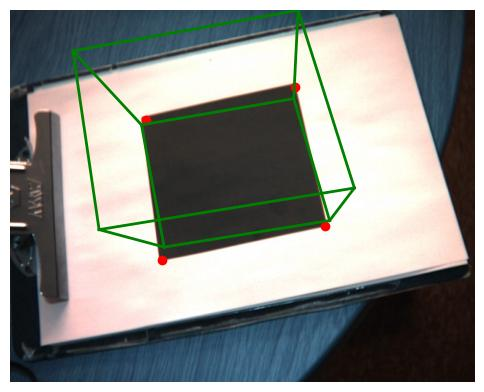

92


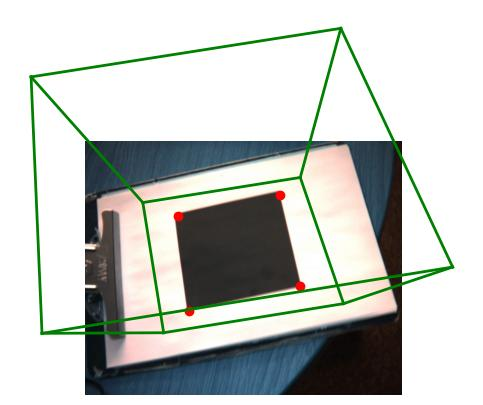

93


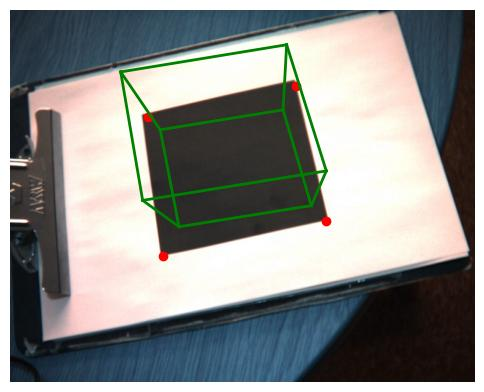

94


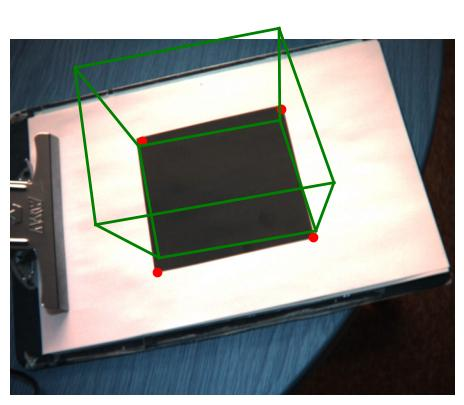

95


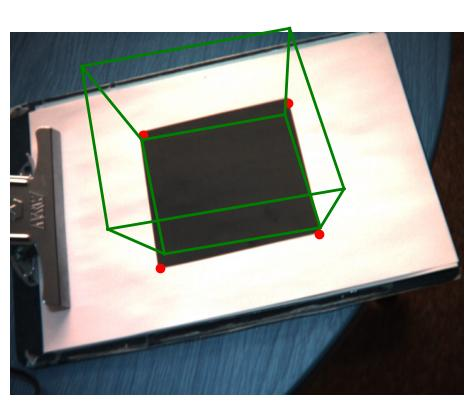

96


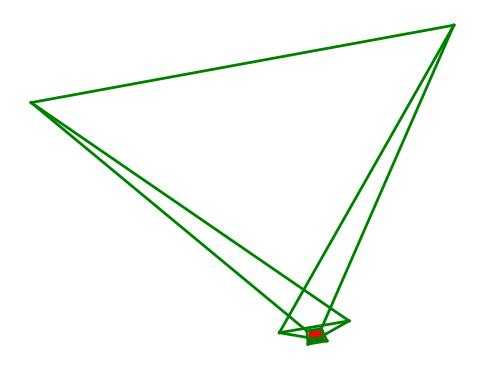

97


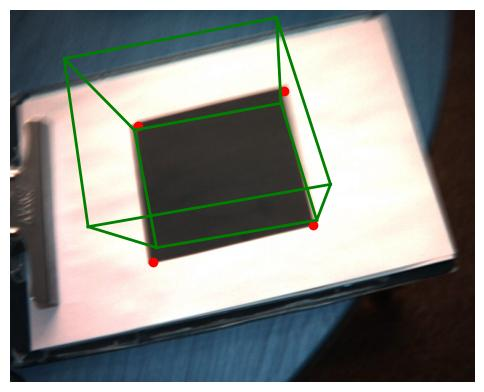

98


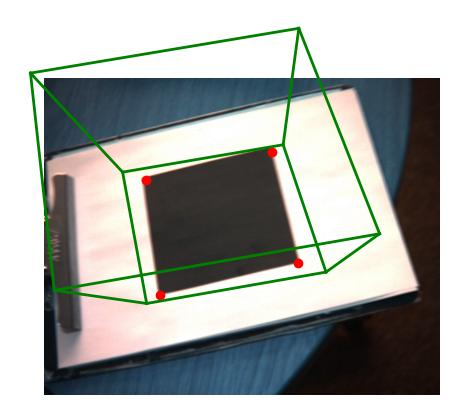

99


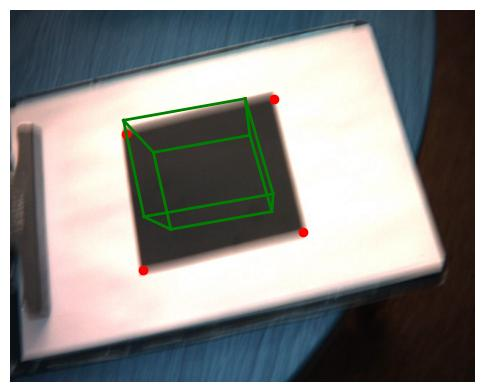

100


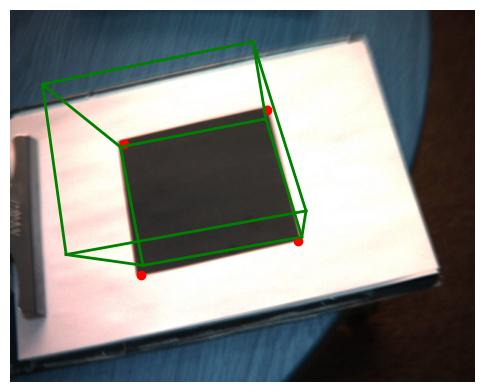

101


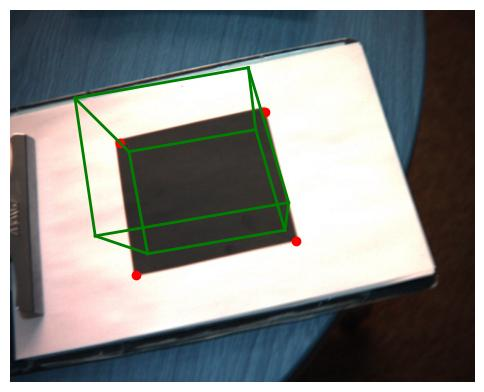

102


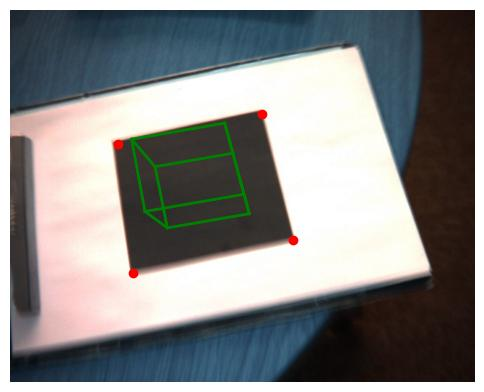

103


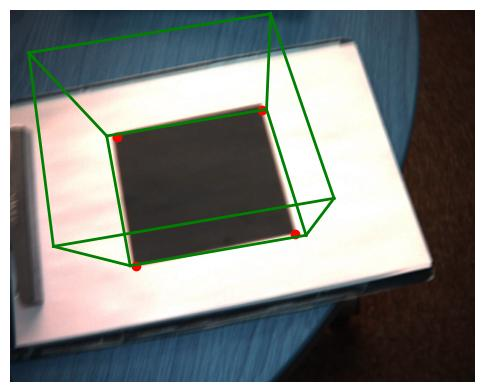

104


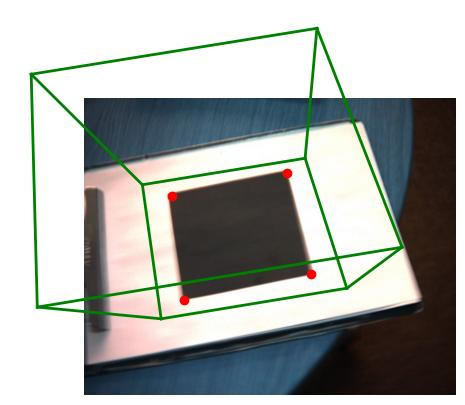

105


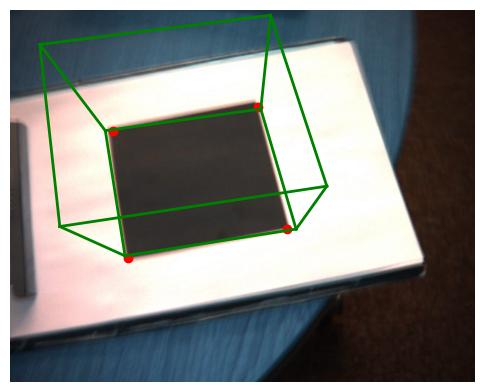

106


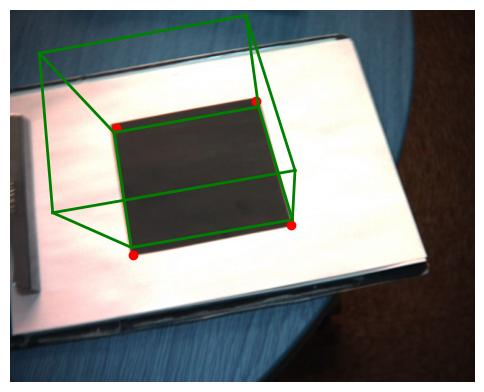

107


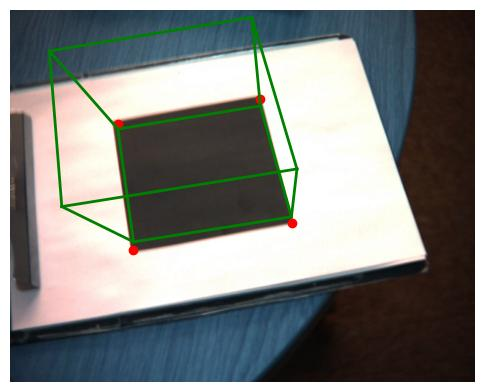

108


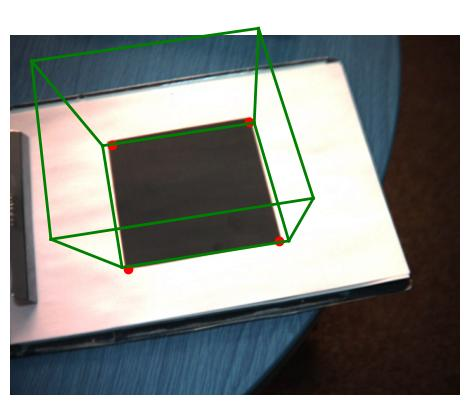

109


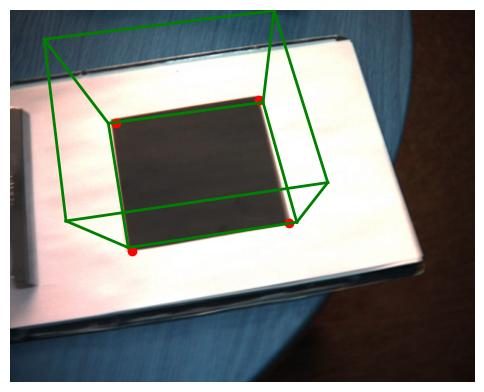

110


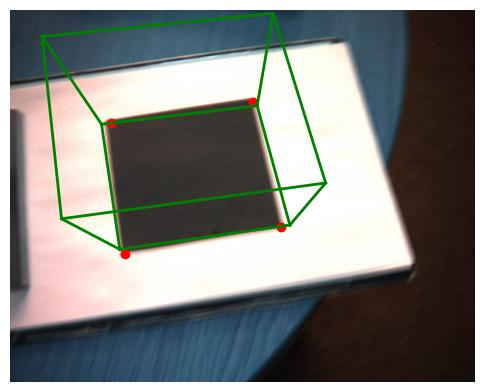

111


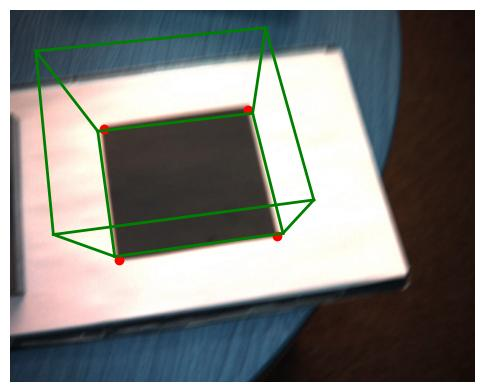

112


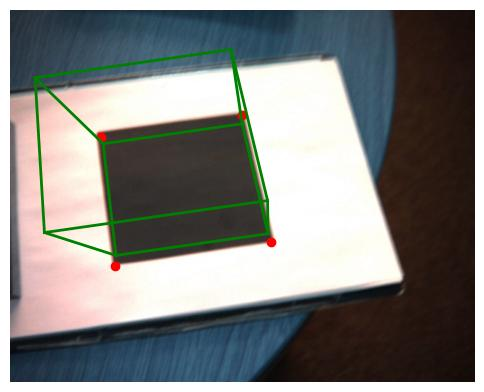

113


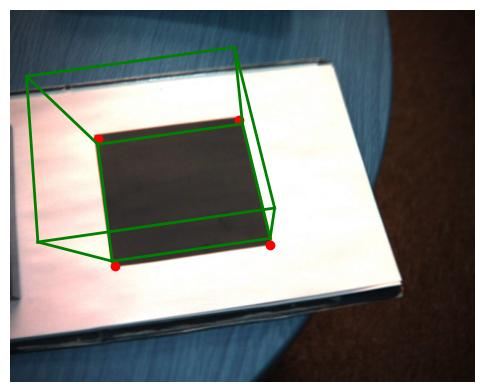

114


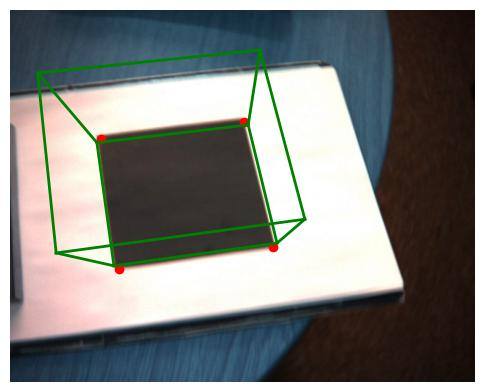

115


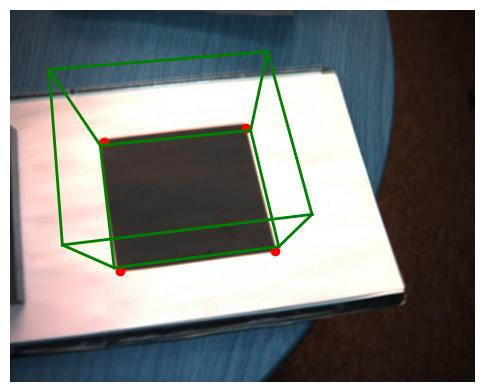

116


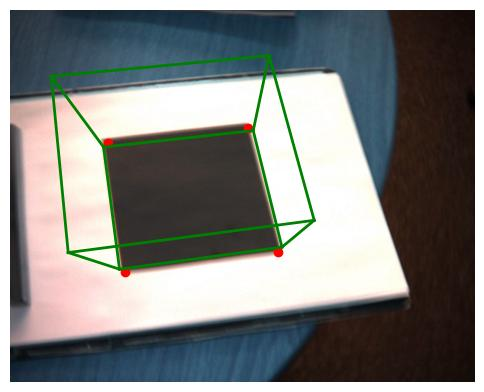

117


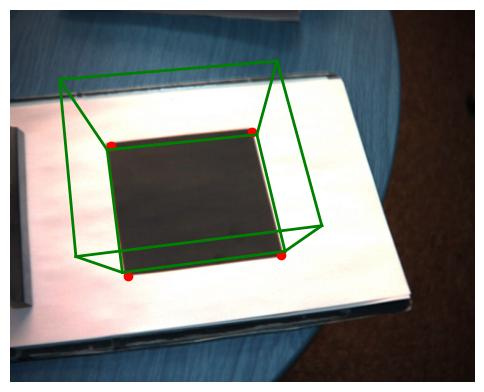

118


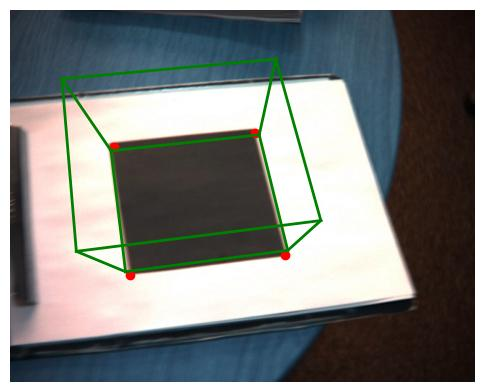

119


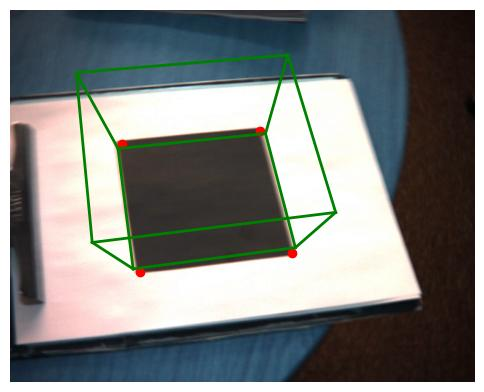

120


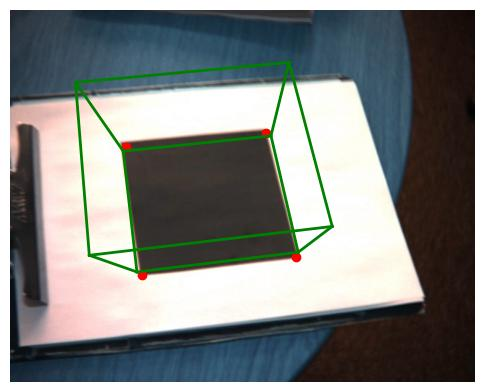

121


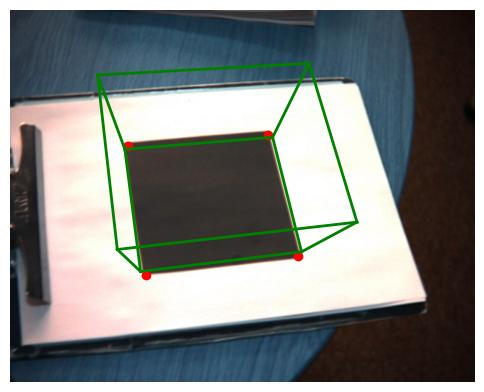

122


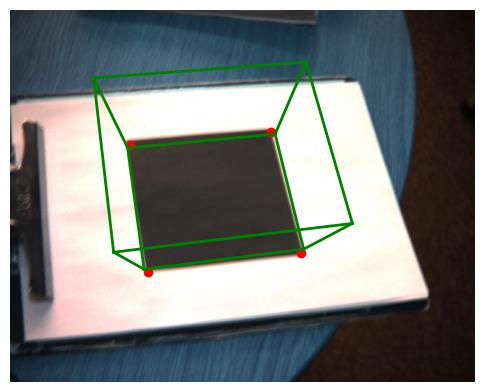

123


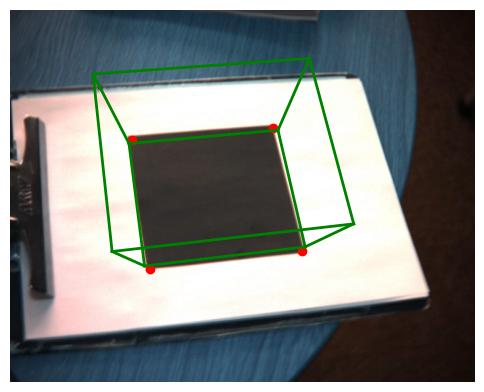

124


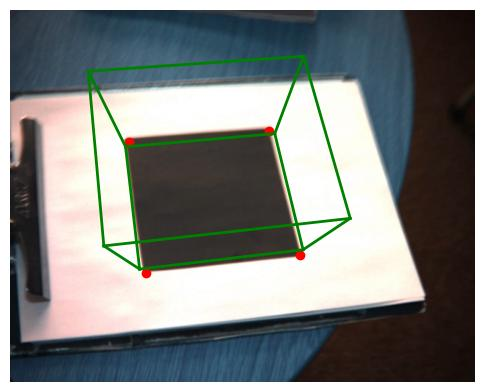

125


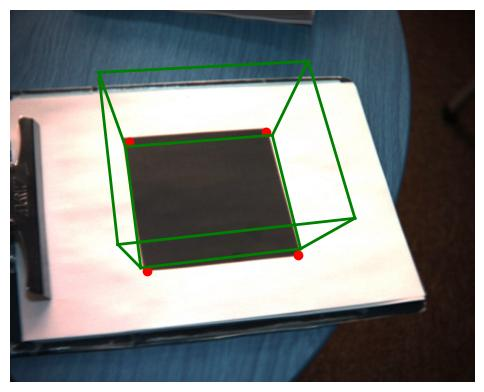

126


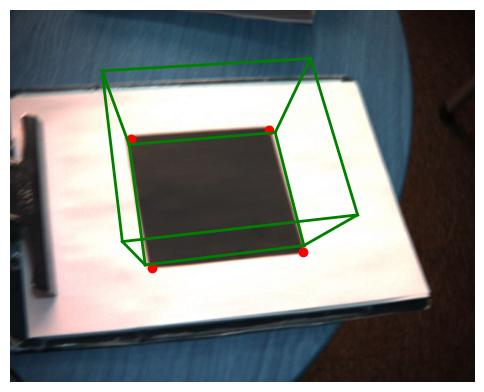

127


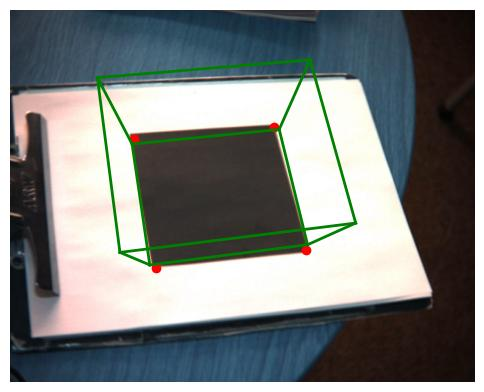

128


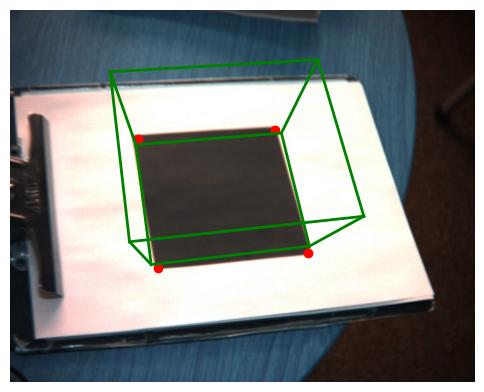

129


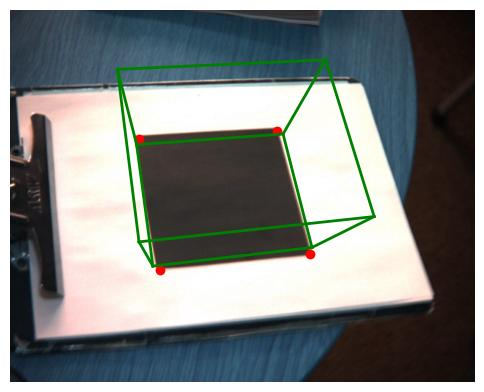

130


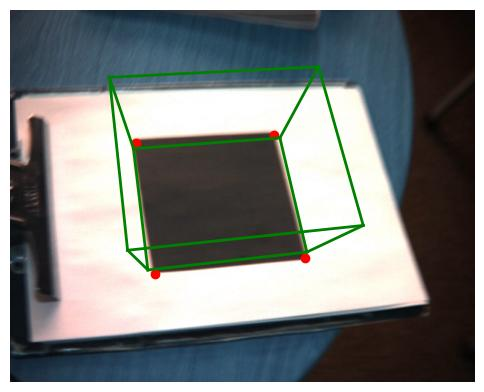

131


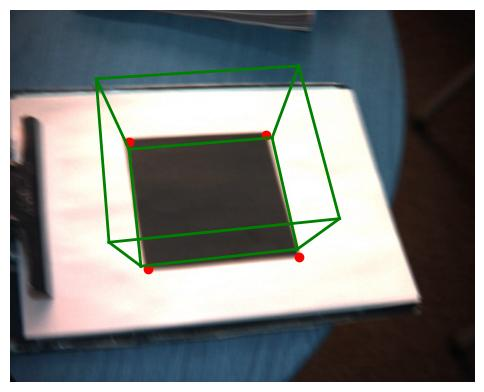

132


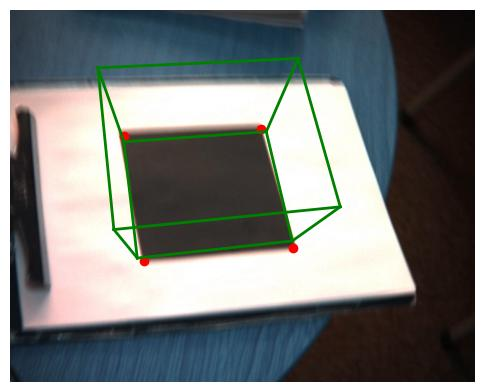

133


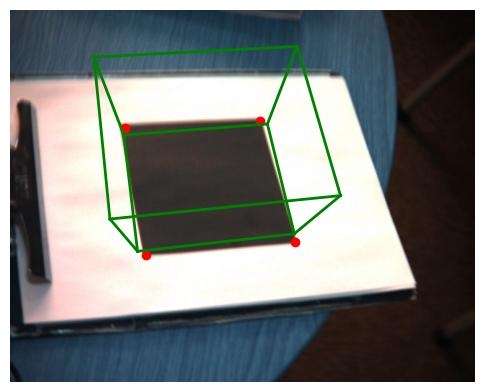

134


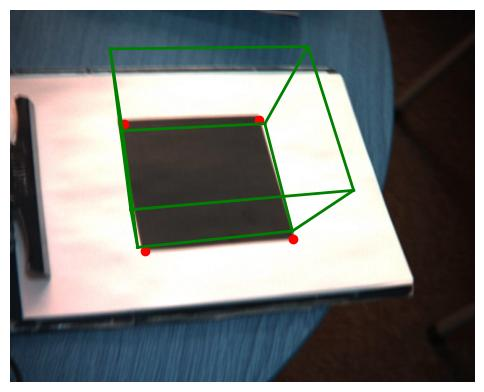

135


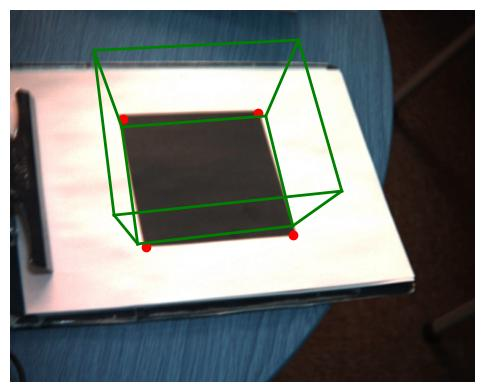

136


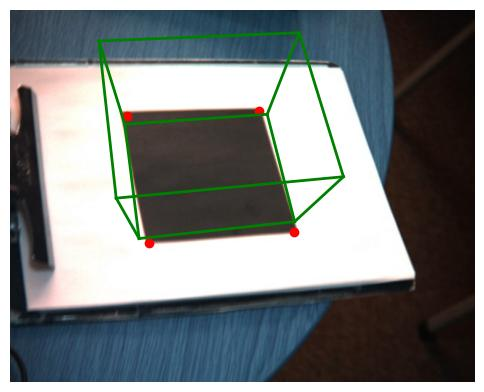

137


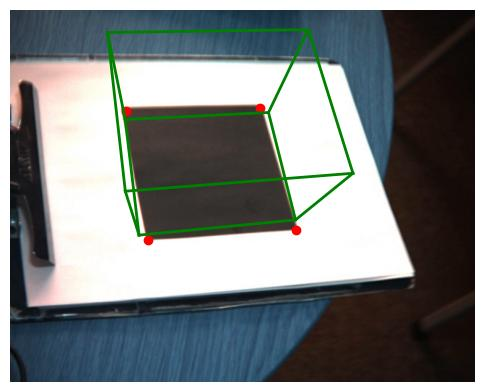

138


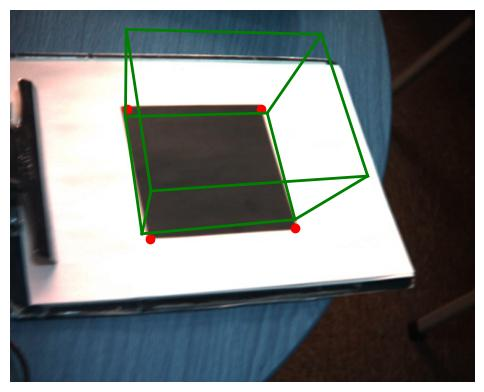

139


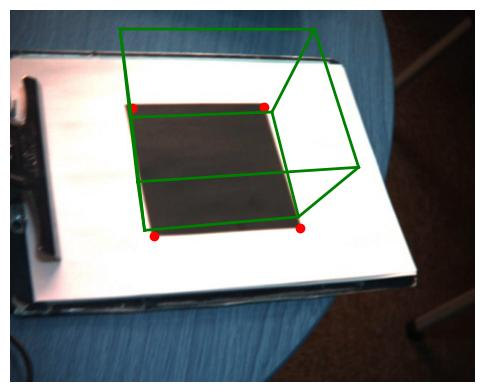

140


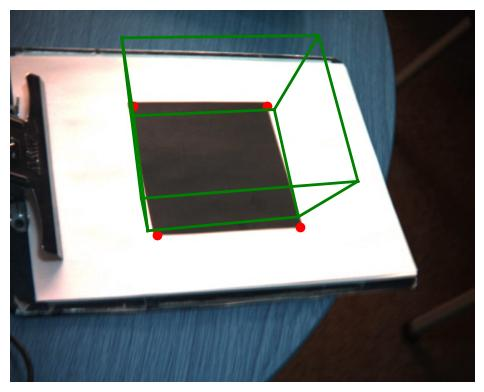

141


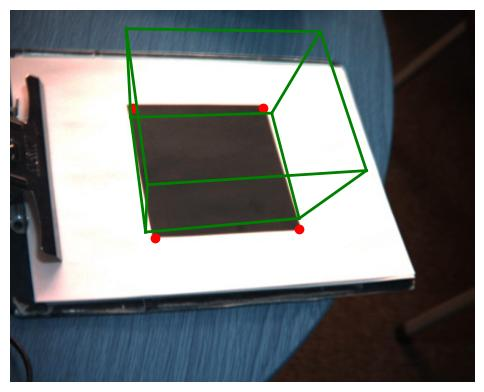

142


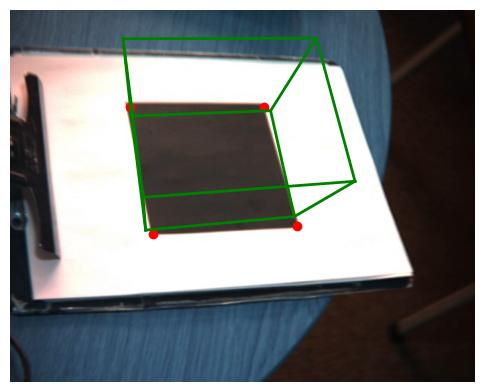

143


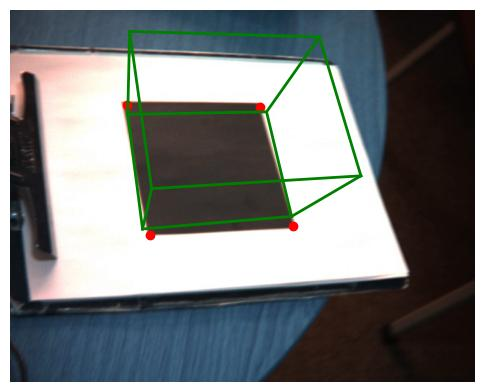

144


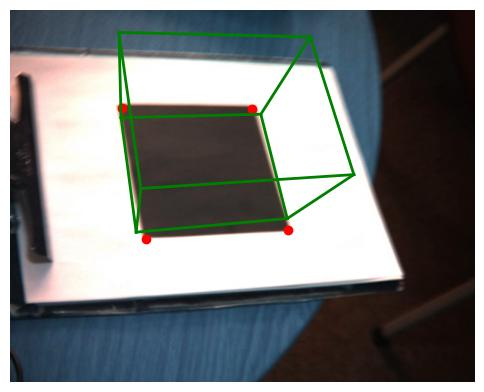

145


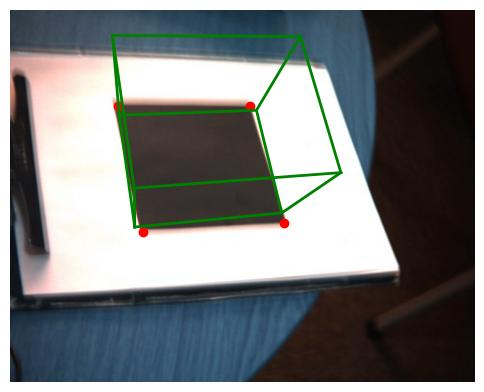

146


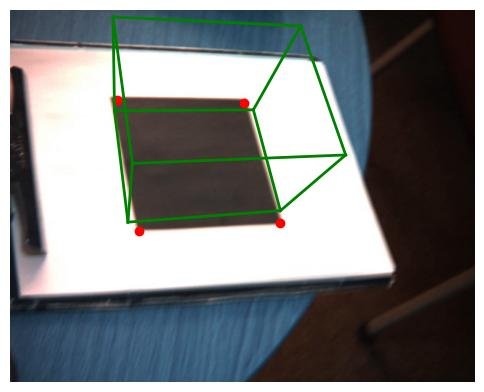

147


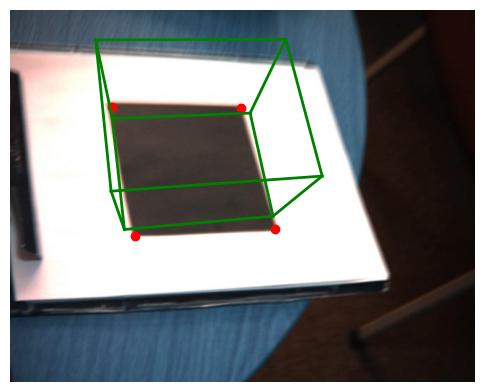

148


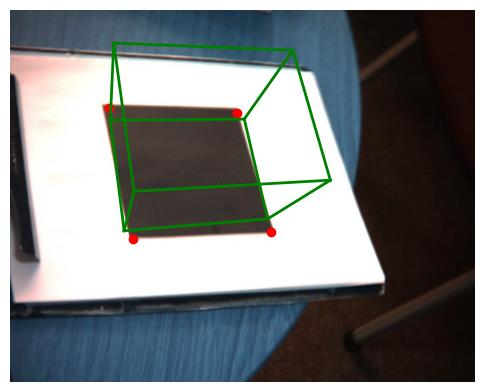

149


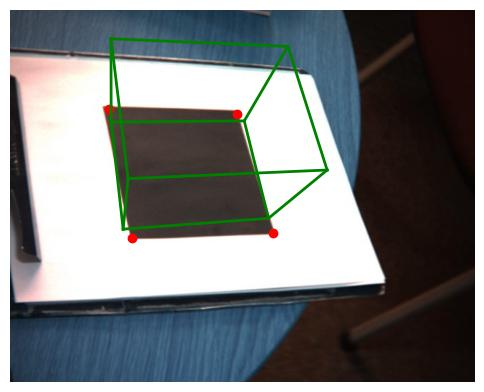

150


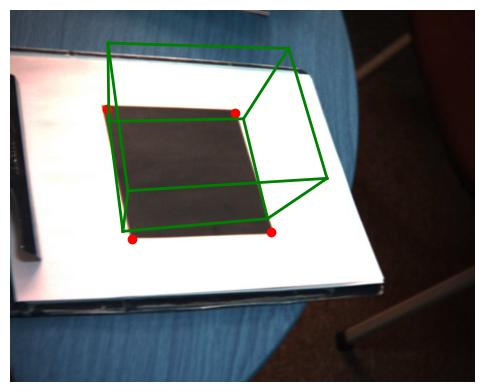

In [25]:
for iFrame in range(1,nFrame):
    print(iFrame)
    xImCart = np.array([LLs[iFrame,:].T, ULs[iFrame,:].T, URs[iFrame,:].T, LRs[iFrame,:].T]).T

    # get a frame from footage 
    im = images[iFrame]

    # Draw image and 2d points
    plt.imshow(im)
    plt.scatter(x = xImCart[0,:], y = xImCart[1,:],c = 'r')

    T = estimatePlanePose(xImCart, XCart, K);

    XWireFrameCartProjected = projectiveCamera(K, T, XWireFrameCart)
    
    # connect points on the bottom surface
    for i in range(0, 4):
        x1 = XWireFrameCartProjected[0, i]
        y1 = XWireFrameCartProjected[1, i]
        if i + 1 < 4:
            x2 = XWireFrameCartProjected[0, i+1]
            y2 = XWireFrameCartProjected[1, i+1]
        else:
            x2 = XWireFrameCartProjected[0, 0]
            y2 = XWireFrameCartProjected[1, 0]
        plt.plot((x1, x2), (y1, y2), linewidth=2, color='green')

    # connect points on the top surface 
    for i in range(4, 8):
        x1 = XWireFrameCartProjected[0, i]
        y1 = XWireFrameCartProjected[1, i]
        if i + 1 < 8:
            x2 = XWireFrameCartProjected[0, i+1]
            y2 = XWireFrameCartProjected[1, i+1]
        else:
            x2 = XWireFrameCartProjected[0, 4]
            y2 = XWireFrameCartProjected[1, 4]
        plt.plot((x1, x2), (y1, y2), linewidth=2, color='green')
    
    # connect corresponding pairs between top and bottom
    for i in range(0, 4):
        x1 = XWireFrameCartProjected[0, i]
        y1 = XWireFrameCartProjected[1, i]
        x2 = XWireFrameCartProjected[0, i+4]
        y2 = XWireFrameCartProjected[1, i+4]
        plt.plot((x1, x2), (y1, y2), linewidth=2, color='green')
        
    plt.axis('off')
    plt.show()

    


One method for improving the results is through optimizing the estimated extrinsic matrix T using nonlinear minimization. A sample of the results are shown below where the homography matrix and the extrinsic matrix were optimized using the minimization function from scipy. Visually, the results underwent drastic improvement compared to the estimated result.

In [26]:
from scipy.optimize import minimize

In [27]:
def error(T, XImCart):
    proj = projectiveCamera(K, T.reshape(4, 4), XCart)
    error = np.mean(sum((XImCart - proj)**2))
    return error

In [28]:
def h_error(HEst, pts1Cart, pts2Cart):
    HEst = HEst.reshape(3,3)
    pts1Cart = pts1Cart[0:2, :]
    pts1Hom = np.concatenate((pts1Cart, np.ones((1,pts1Cart.shape[1]))), axis=0)
    pts2EstHom = np.matmul(HEst,pts1Hom)
    pts2EstCart = pts2EstHom[0:2,:] / np.tile([pts2EstHom[2,:]],(2,1))
    error = np.sum((pts2Cart - pts2EstCart)**2)
    return error

In [29]:
def estimatePlanePose_Opt(XImCart,XCart,K):
    T = []
    
    # Convert Cartesian image points XImCart to homogeneous representation XImHom
    XImHom = np.concatenate((XImCart, np.ones((1,XImCart.shape[1]))), axis=0)
    
    # Convert image co-ordinates XImHom to normalized camera coordinates XCamHom    
    XCamHom = np.linalg.inv(K) @ XImHom
        
    # Estimate homography H mapping homogeneous (x,y) coordinates of positions
    # in real world to XCamHom (convert XCamHom to Cartesian, calculate the homography) -
    # use the routine you wrote for Practical 1B
    XCamCart = XCamHom[0:2,:] / np.tile([XCamHom[2,:]],(2,1))

    HEst = calcBestHomography(XCart, XCamCart)
    # optimze the homography here, not strictly necessary in this case
    HEst_opt = minimize(h_error, HEst.reshape(9), args=(XCart, XCamCart)).x.reshape(3, 3)
    HEst = HEst_opt
    
    # Estimate first two columns of rotation matrix R from the first two
    # columns of H using the SVD. NOTE: You do not need to transpose v from linalg.svd    
    omega = HEst[:, 0:2]
        
    u, s, vh = np.linalg.svd(omega)
    I = np.array([[1.0, 0], [0, 1.0], [0, 0]])
    omega_hat = u @ I @ vh
    

    # Estimate the third column of the rotation matrix by taking the cross
    # product of the first two columns
    col_3 = np.cross(omega_hat[:, 0], omega_hat[:, 1]).reshape(3, 1)
            
    # Check that the determinant of the rotation matrix is positive - if not then multiply last column by -1.
    rot_mat = np.hstack((omega_hat, col_3))
    det = np.linalg.det(rot_mat)
    if det < 0:
        col_3 = col_3 * -1
    
    # Estimate the translation t by finding the appropriate scaling factor k
    # and applying it to the third colulmn of H
    k = 0
    for m in range(3):
        for n in range(2):
            k += omega[m, n] / omega_hat[m, n] / 6

    tau = HEst[:, 2].reshape(3, 1) / k
        
    # Check whether t_z is negative - if it is then multiply t by -1 and
    # the first two columns of R by -1.
    if tau[-1] < 0:
        tau = tau * -1
        omega_hat = omega_hat * -1
                
    # Assemble transformation into matrix form
    T = np.hstack((omega_hat, col_3, tau))
    T = np.vstack((T, np.array([0,0,0,1])))
    
    return T 

1


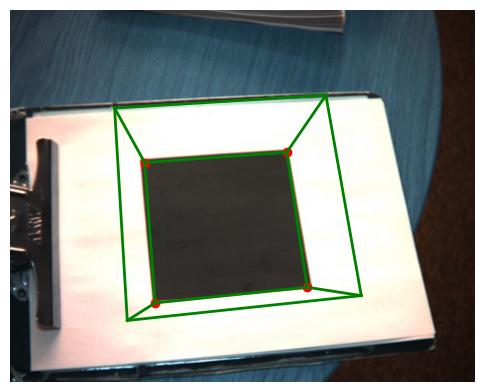

2


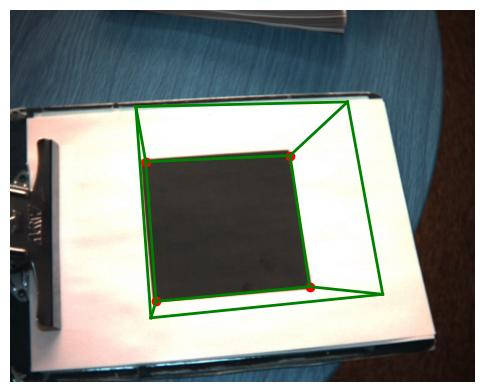

3


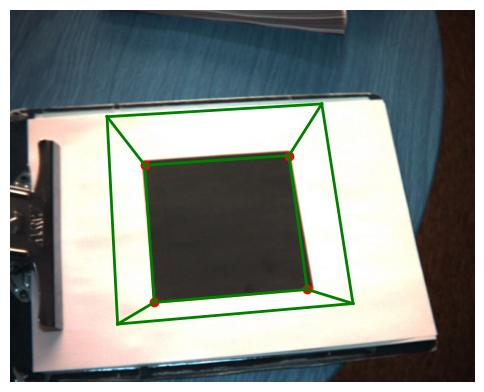

4


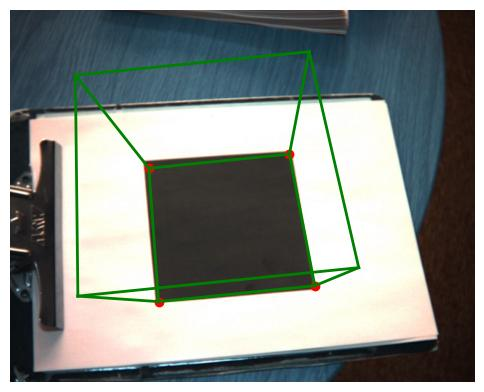

5


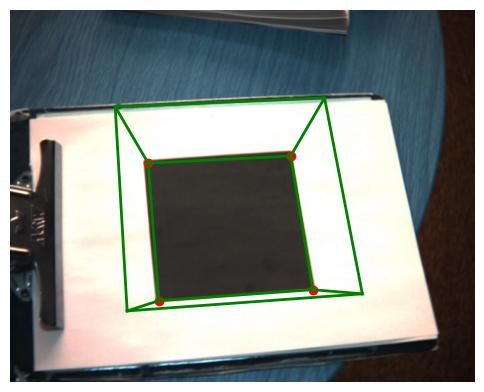

6


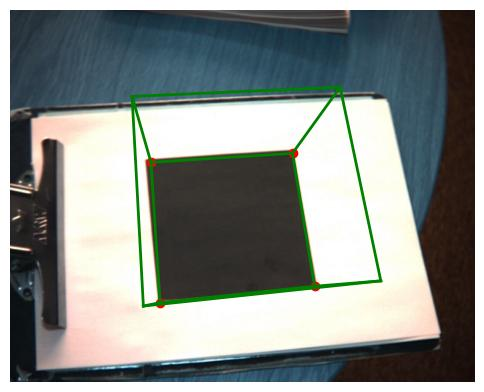

7


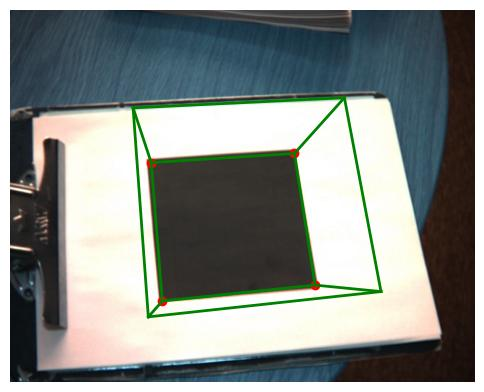

8


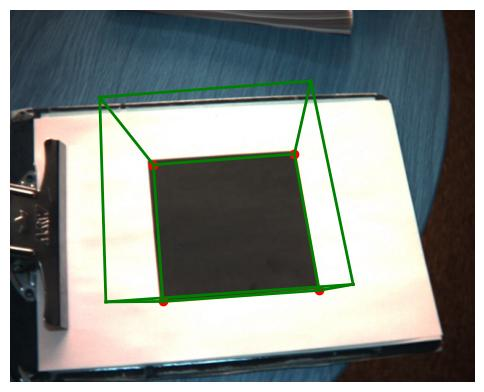

9


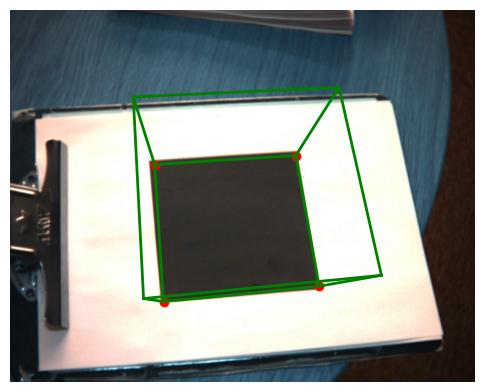

10


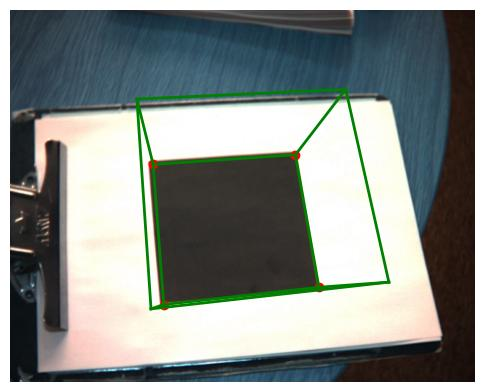

11


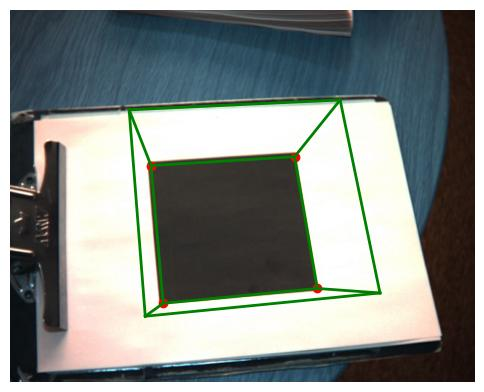

12


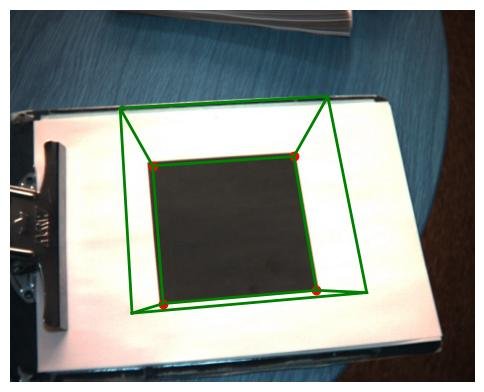

13


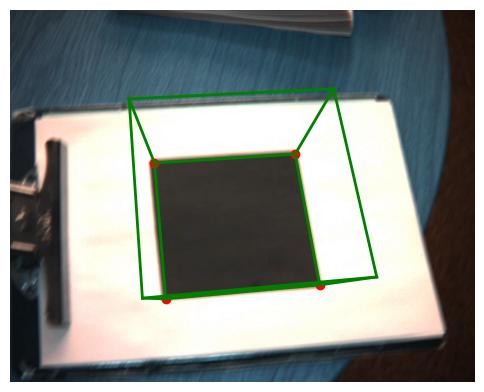

14


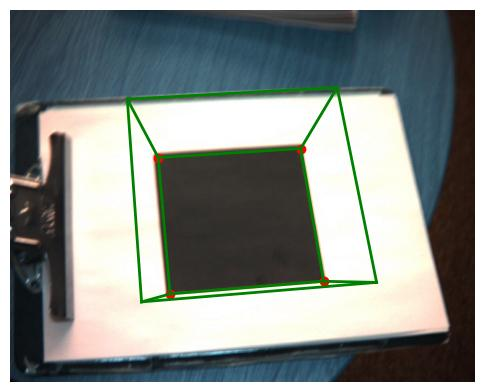

15


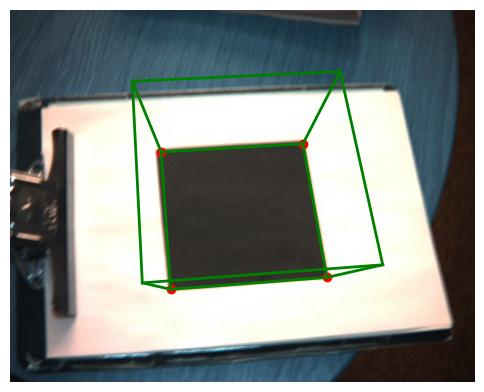

16


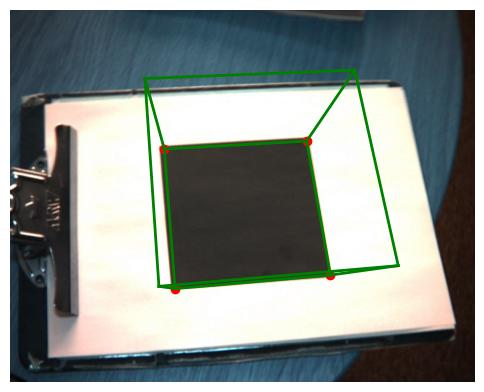

17


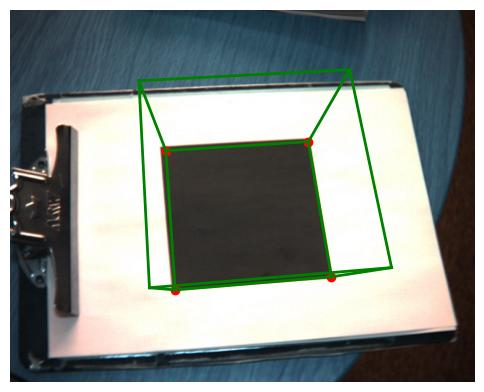

18


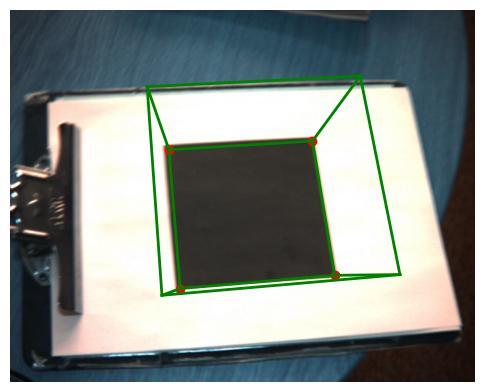

19


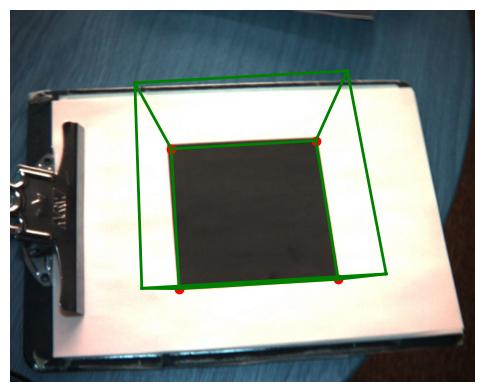

20


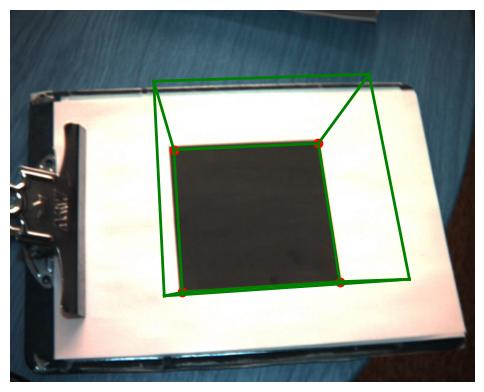

21


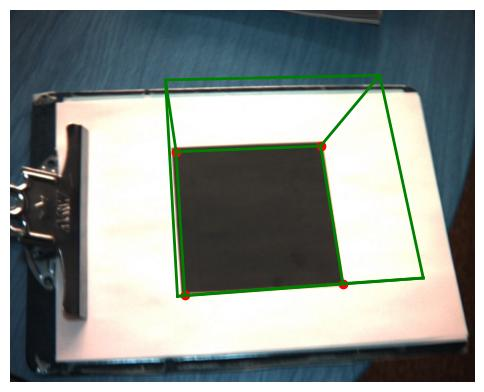

22


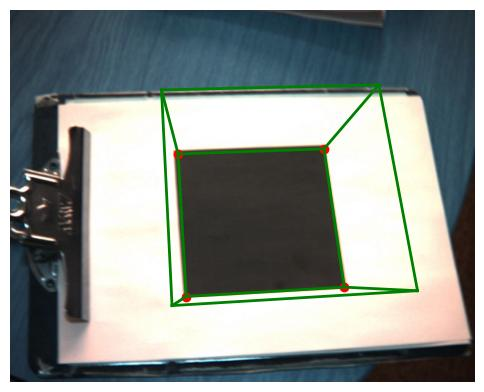

23


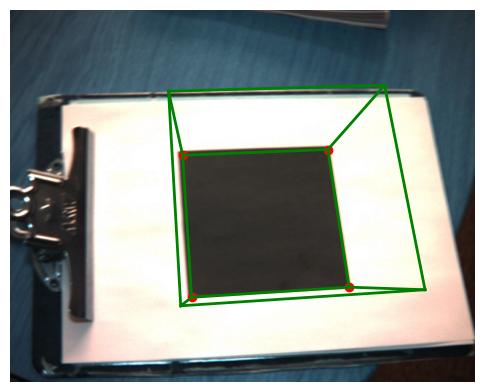

24


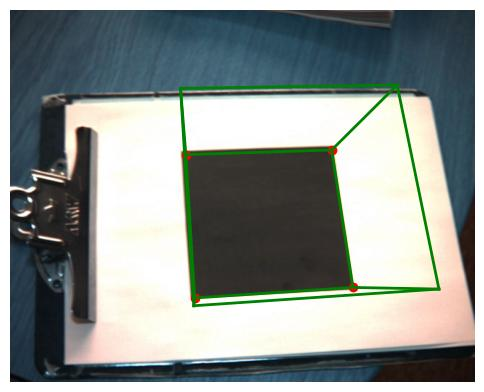

25


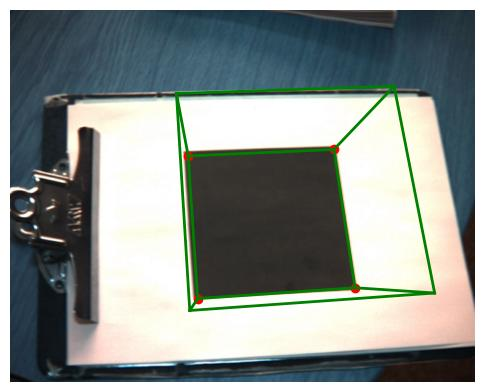

26


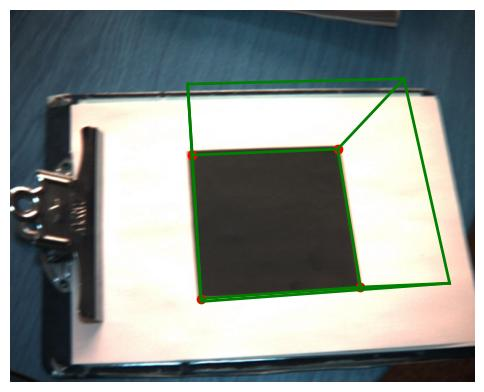

27


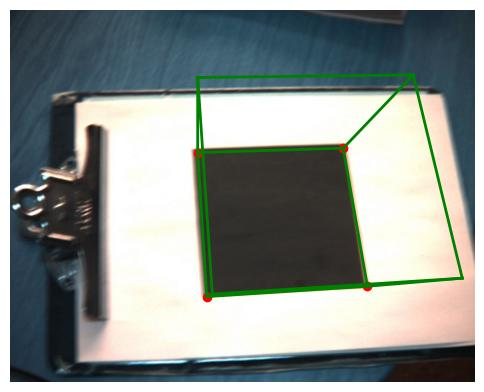

28


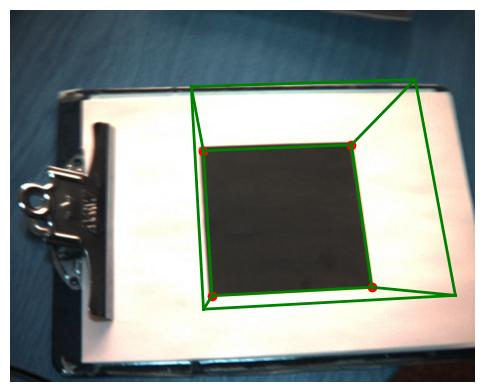

29


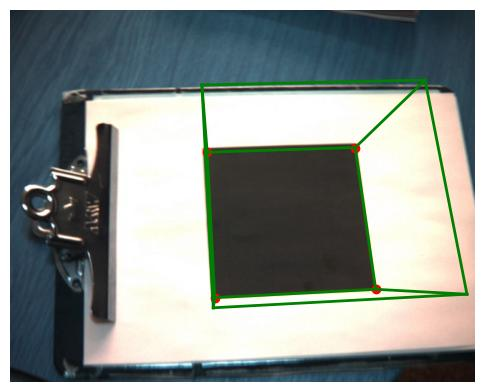

30


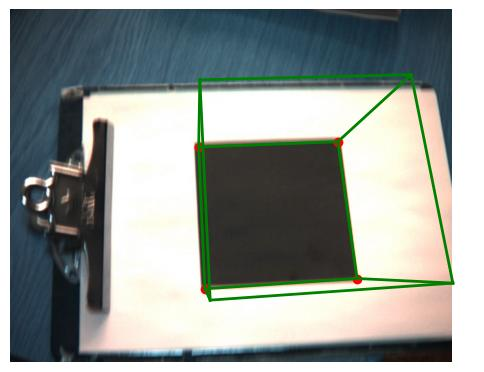

31


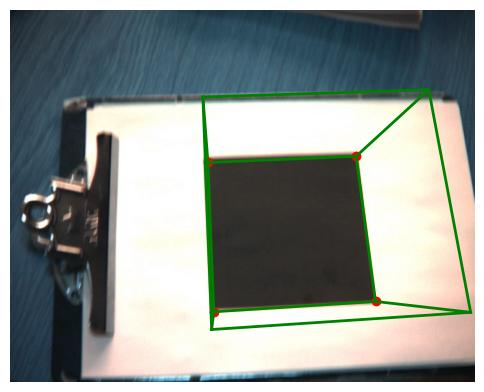

32


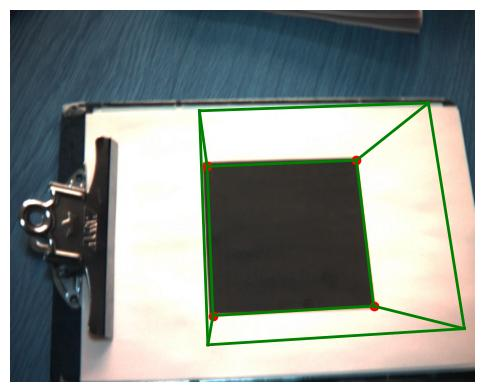

33


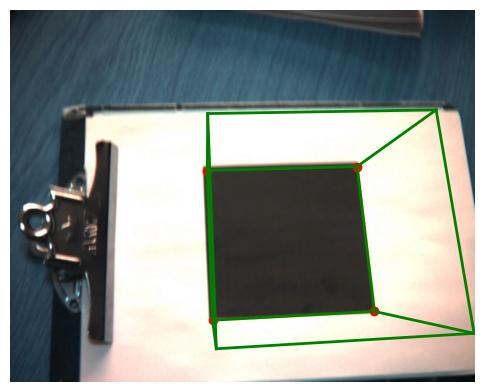

34


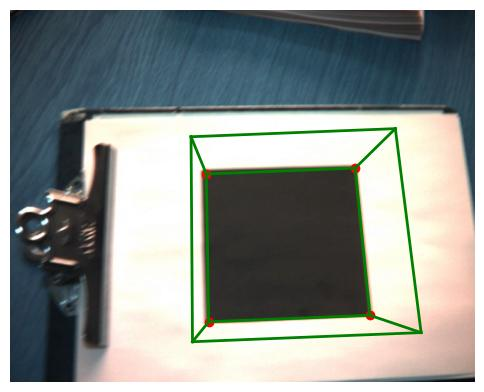

35


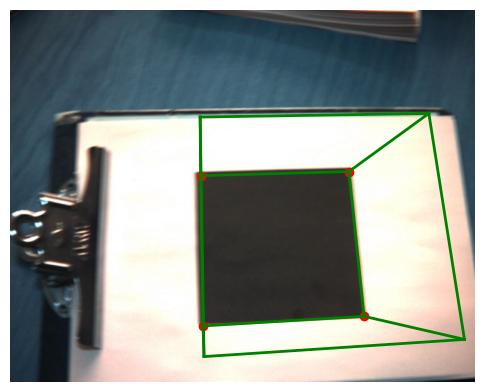

36


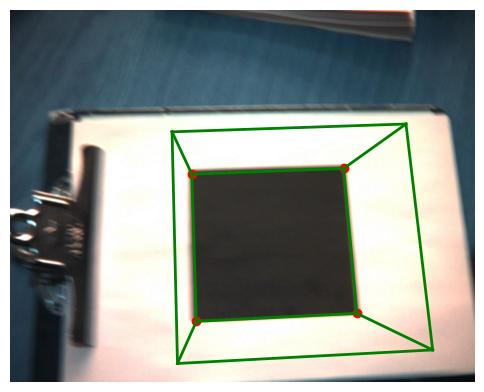

37


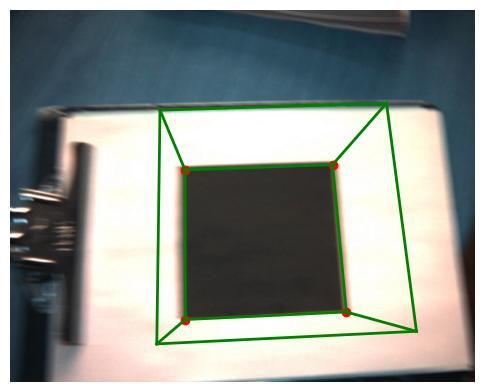

38


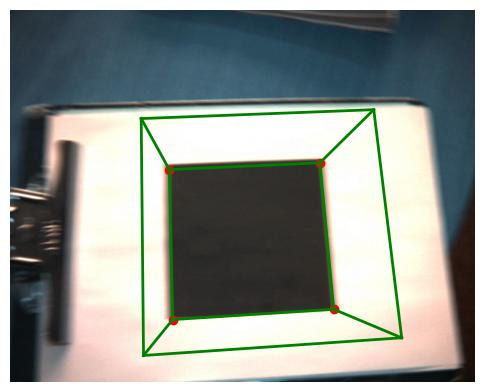

39


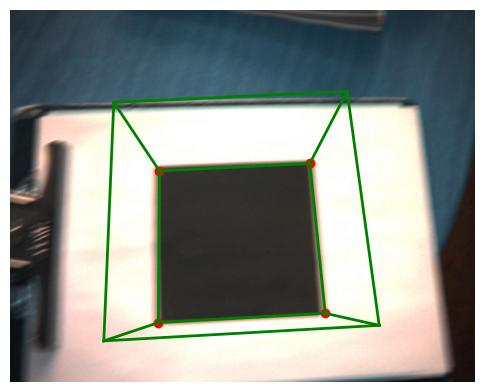

40


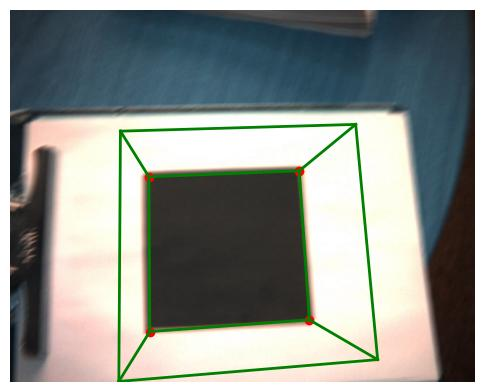

41


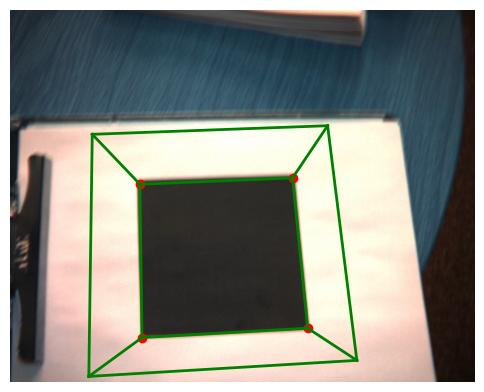

42


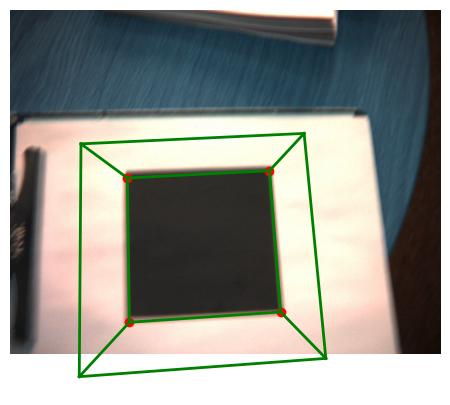

43


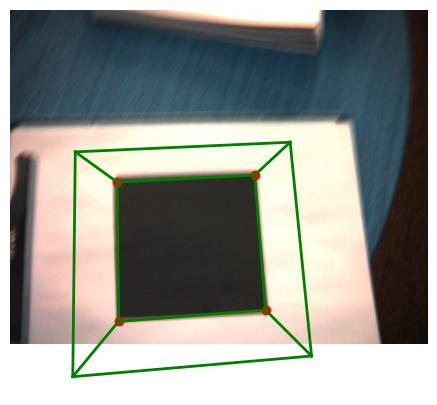

44


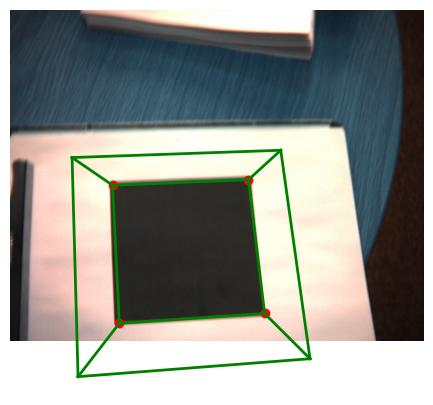

45


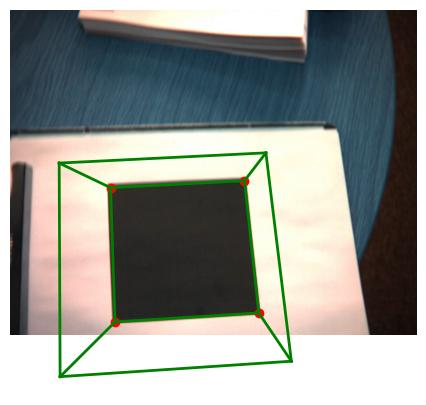

46


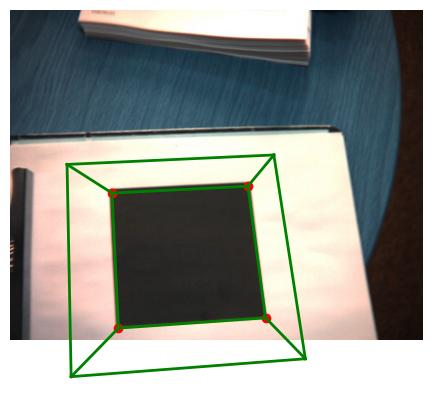

47


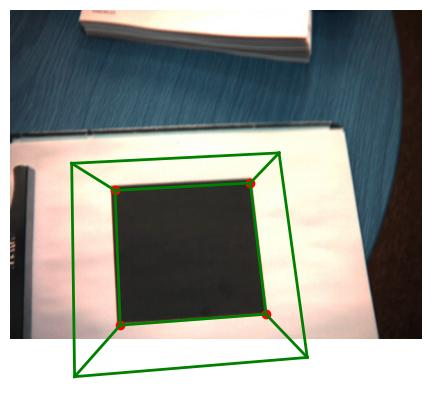

48


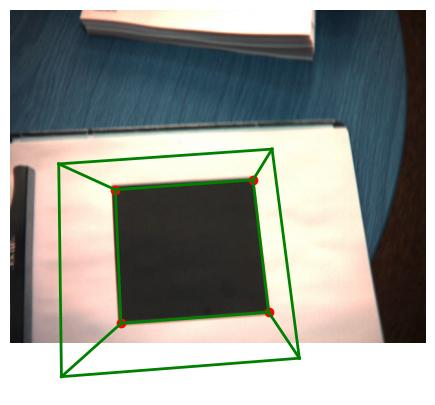

49


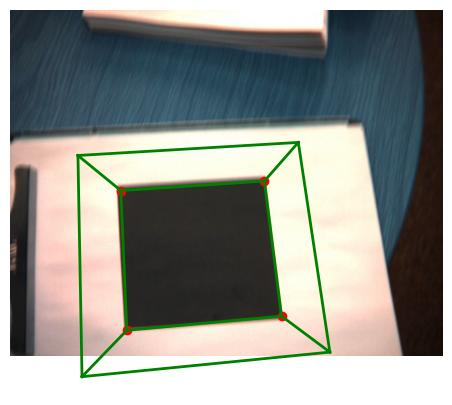

50


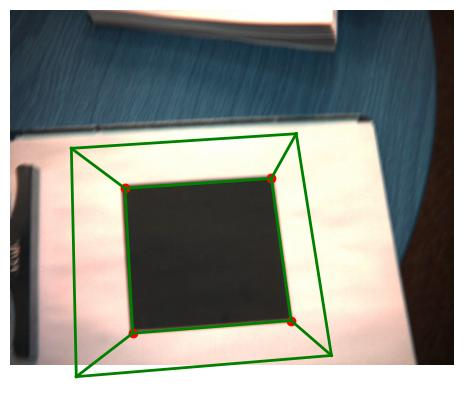

51


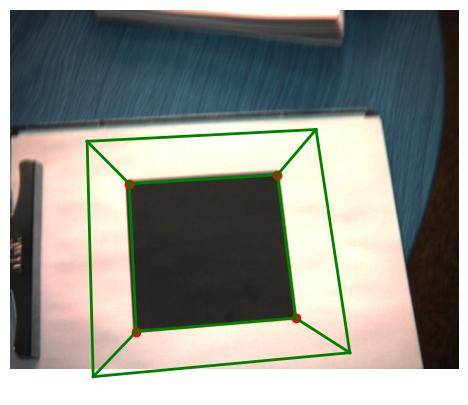

52


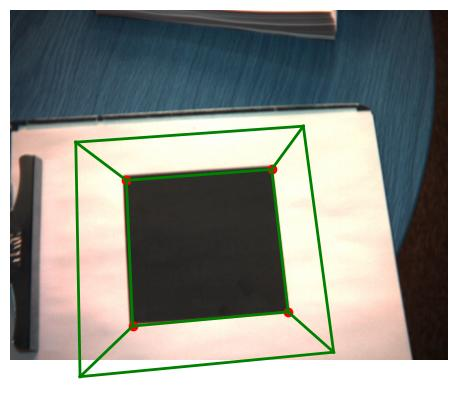

53


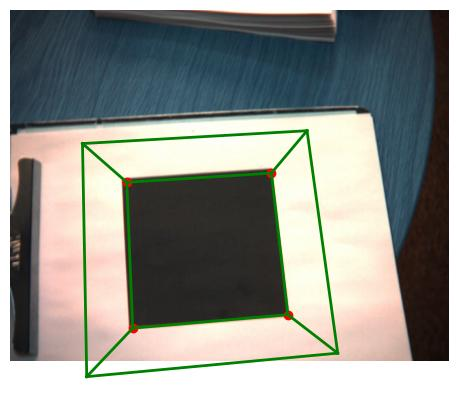

54


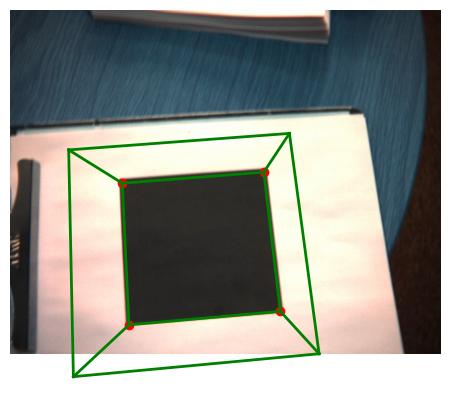

55


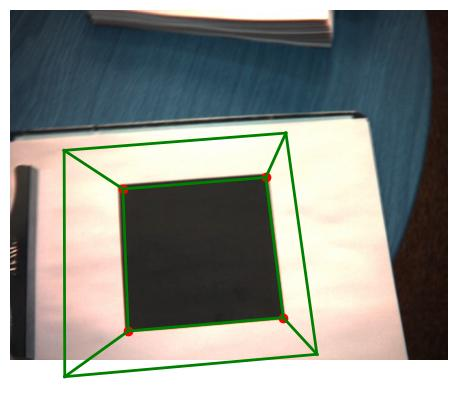

56


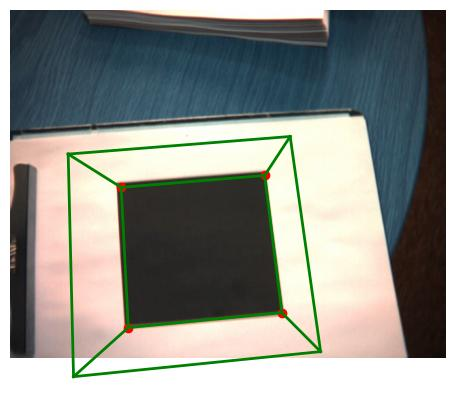

57


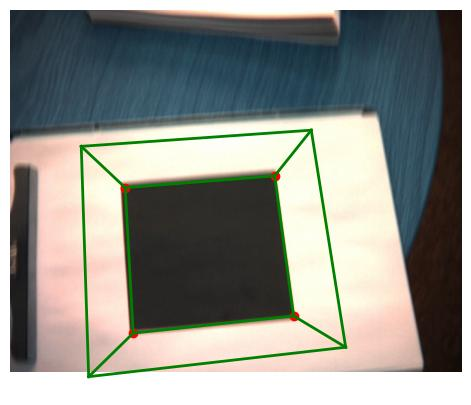

58


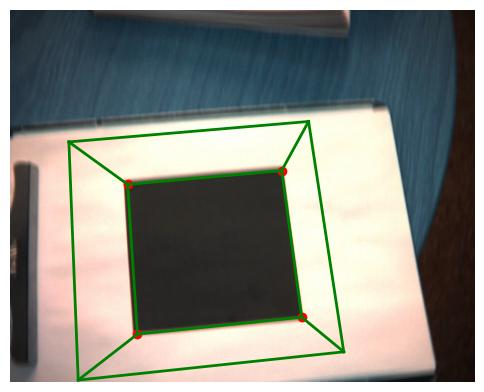

59


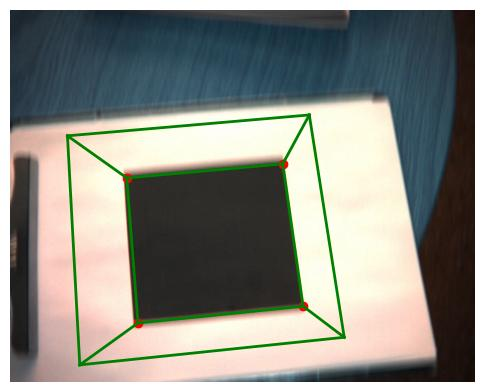

60


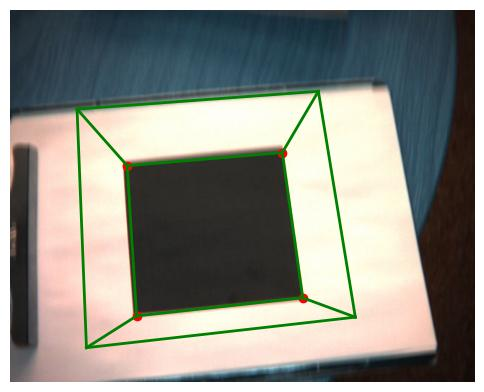

61


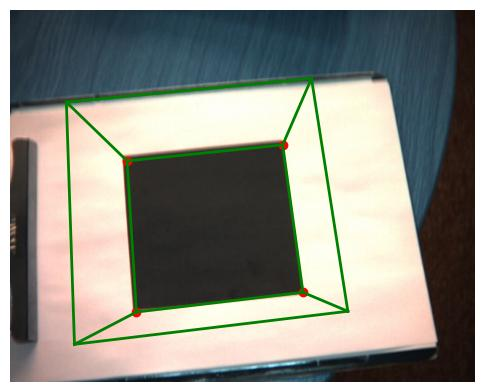

62


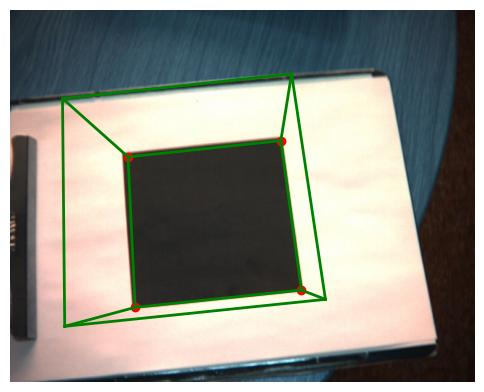

63


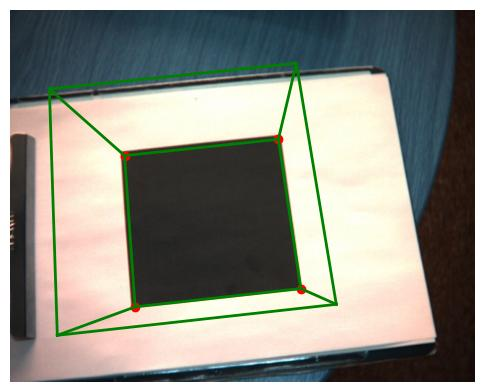

64


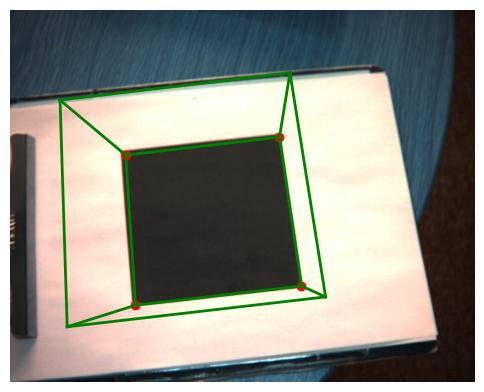

65


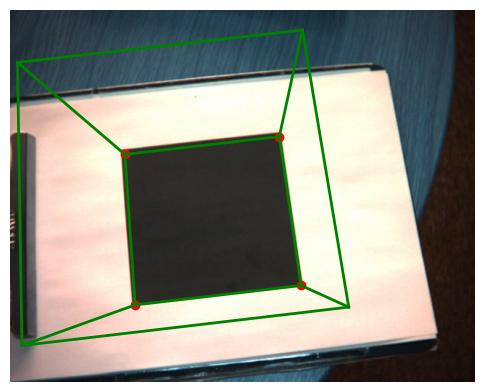

66


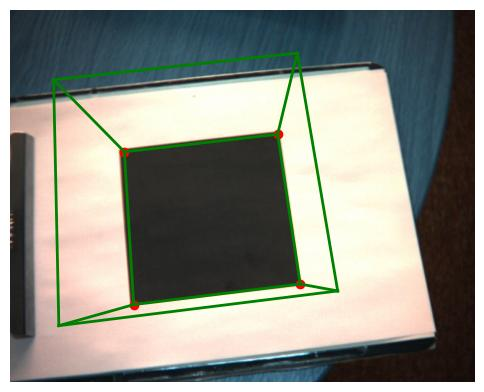

67


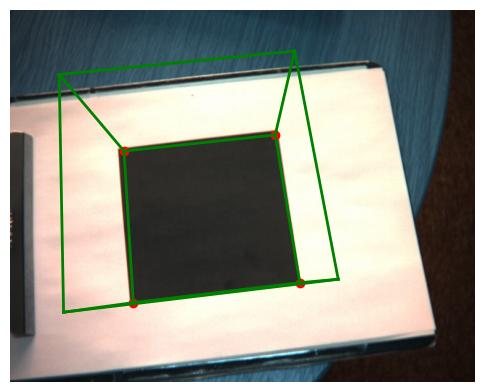

68


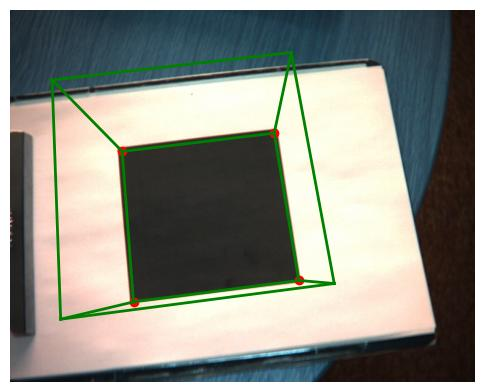

69


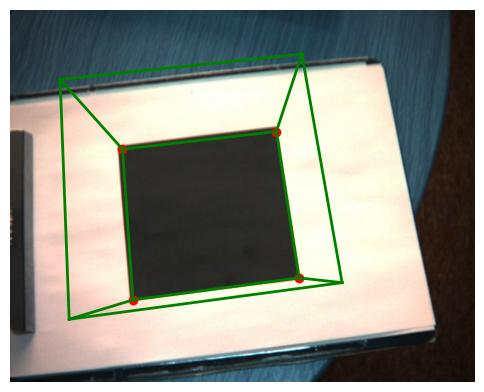

70


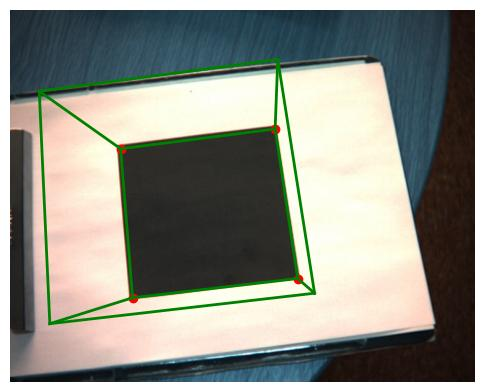

71


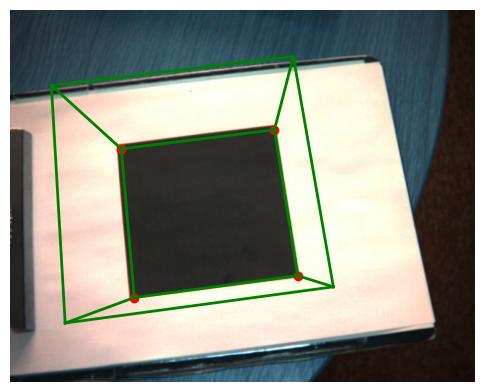

72


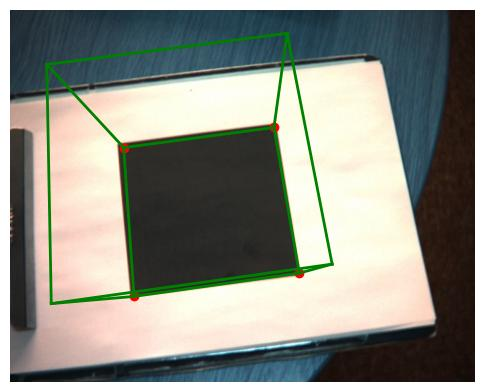

73


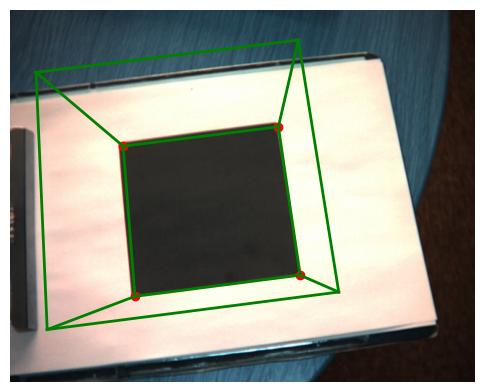

74


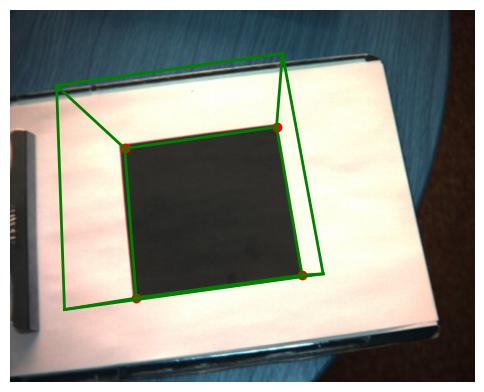

75


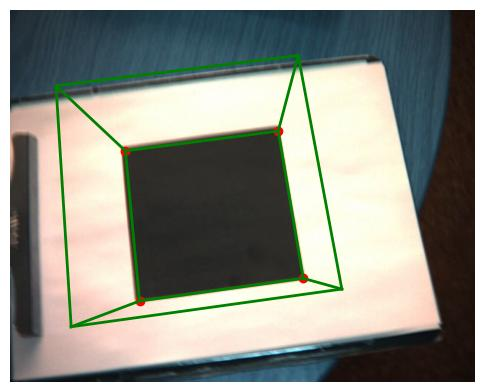

76


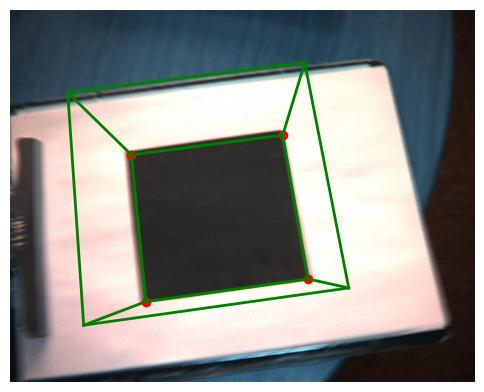

77


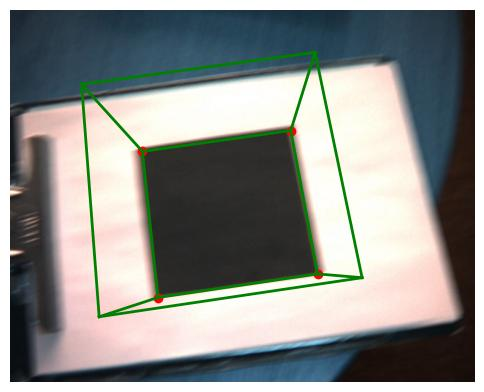

78


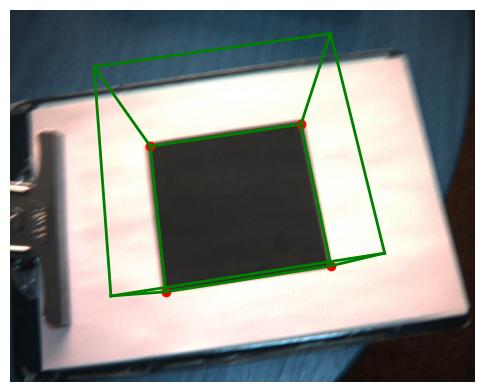

79


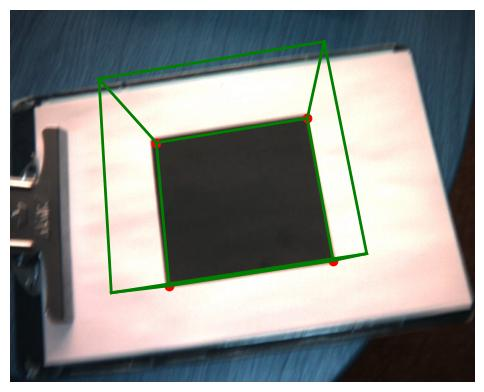

80


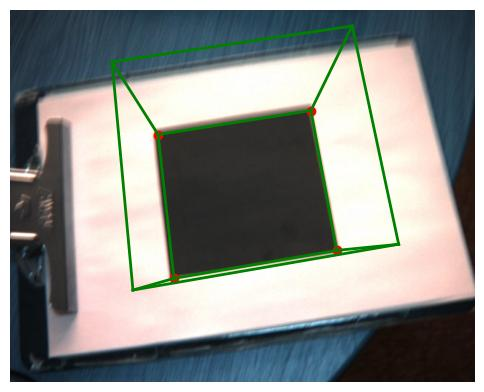

81


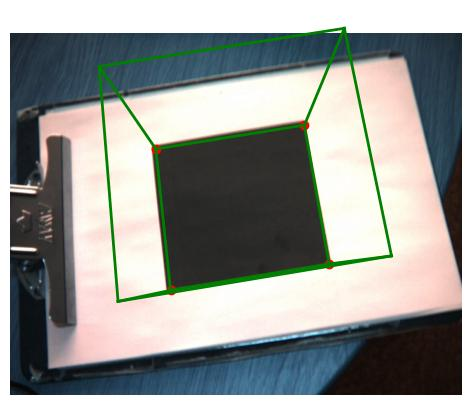

82


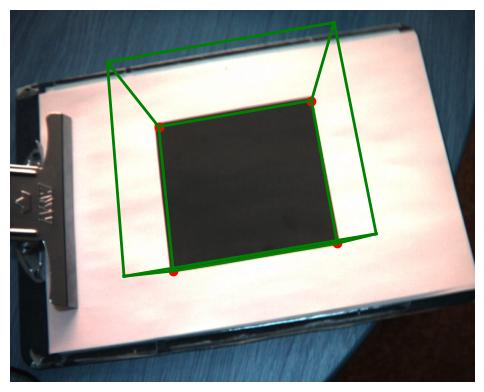

83


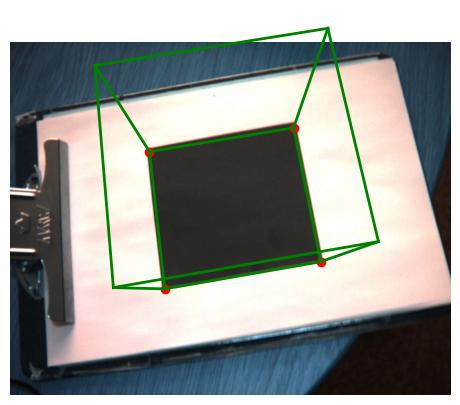

84


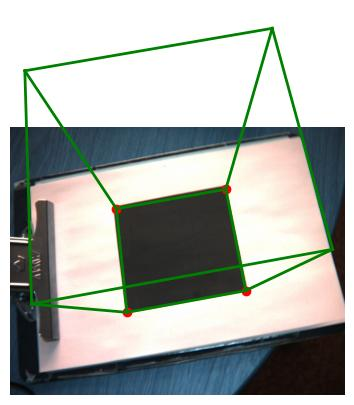

85


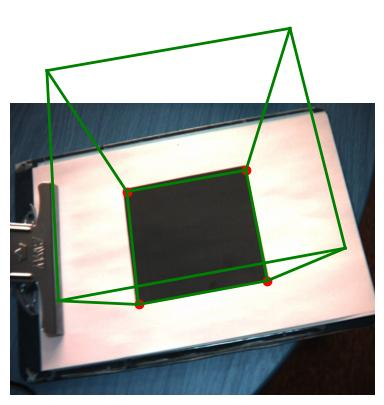

86


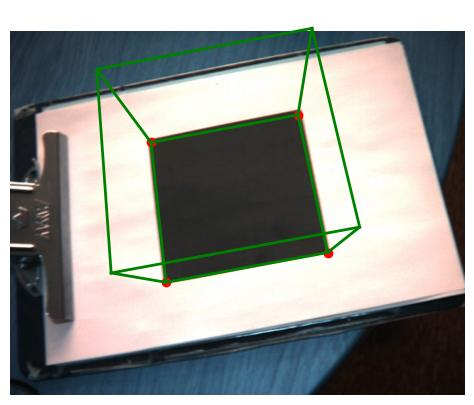

87


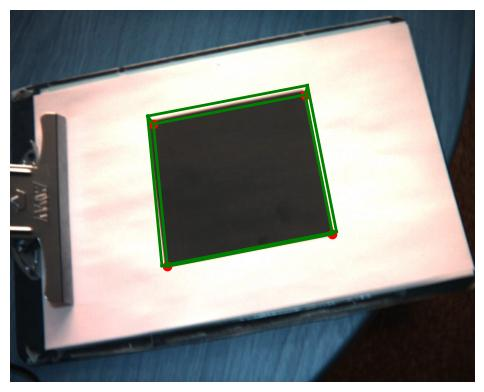

88


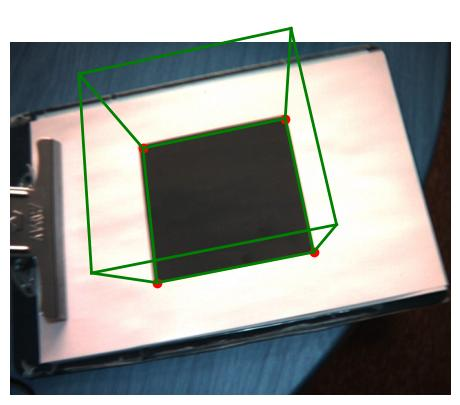

89


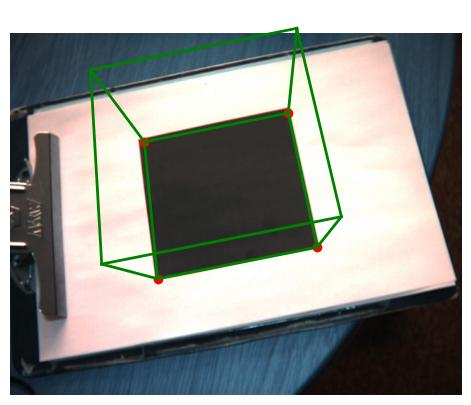

90


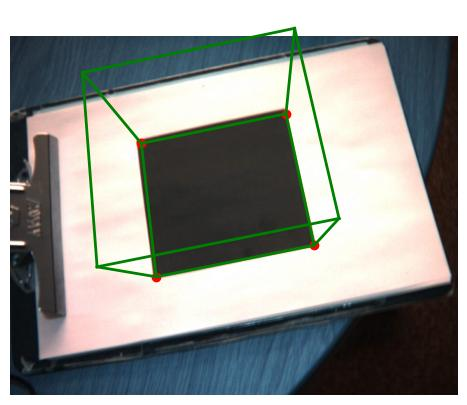

91


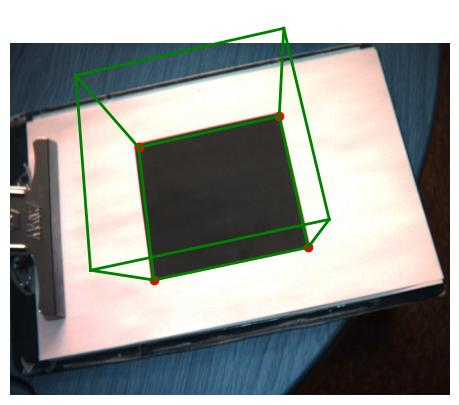

92


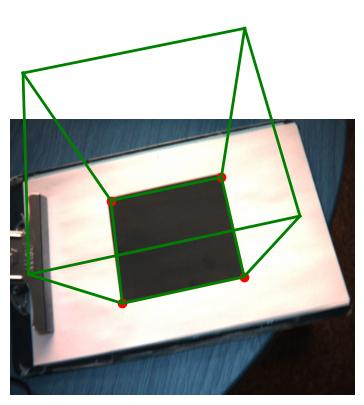

93


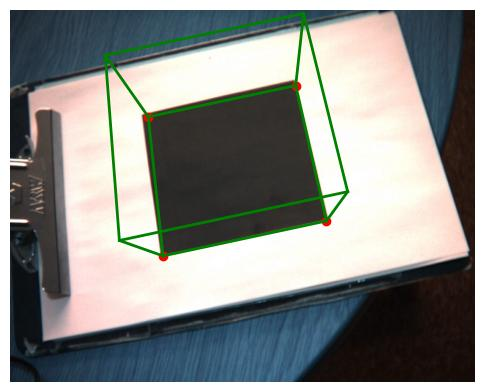

94


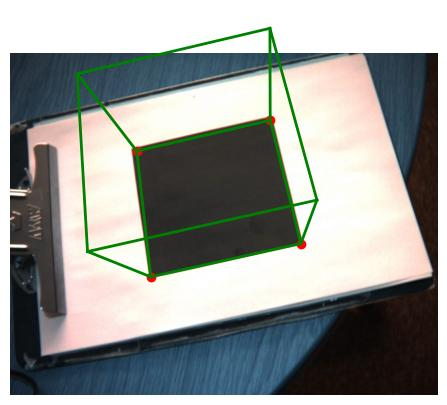

95


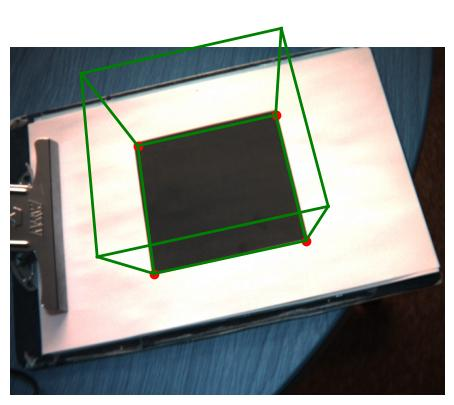

96


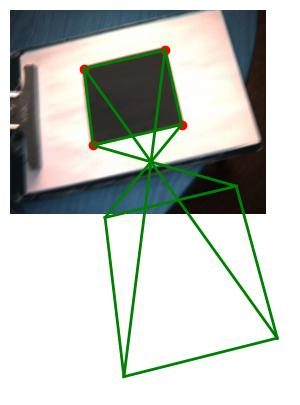

97


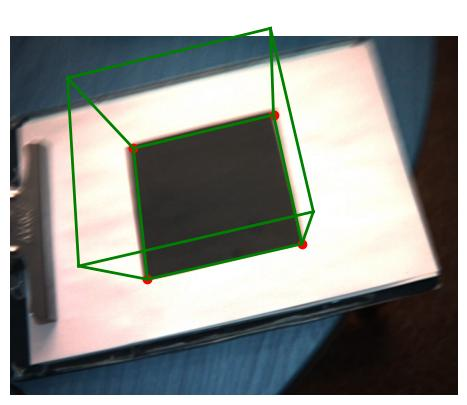

98


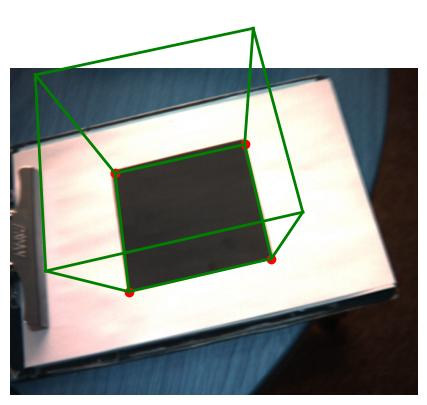

99


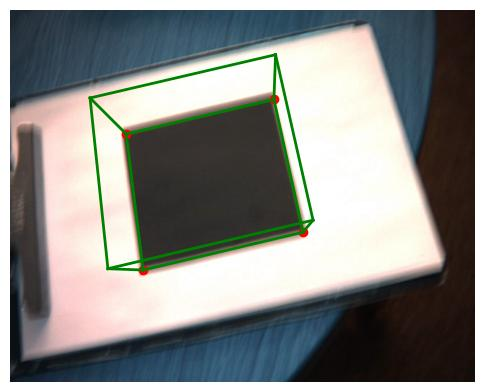

100


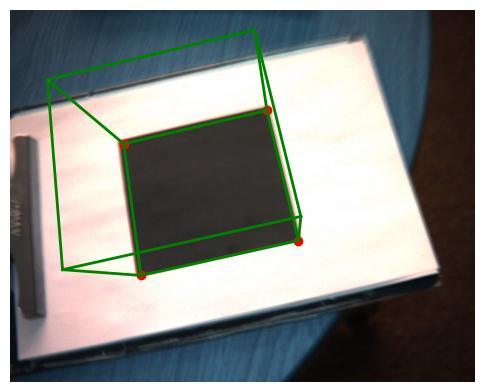

101


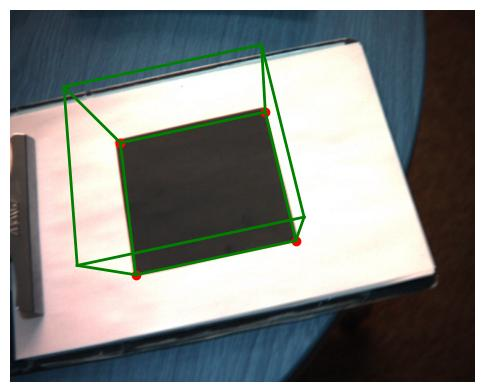

102


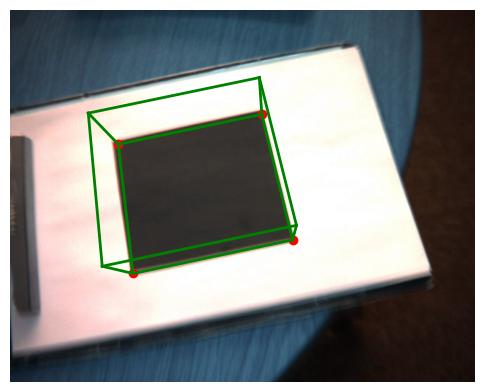

103


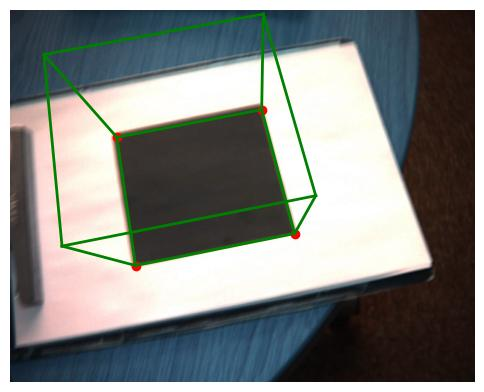

104


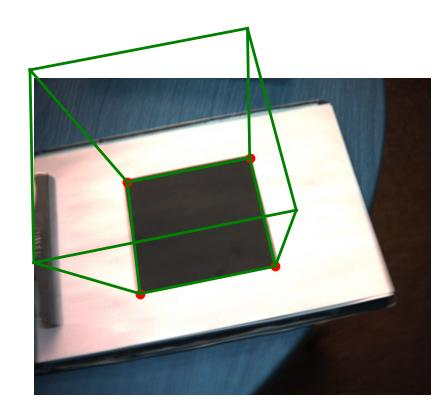

105


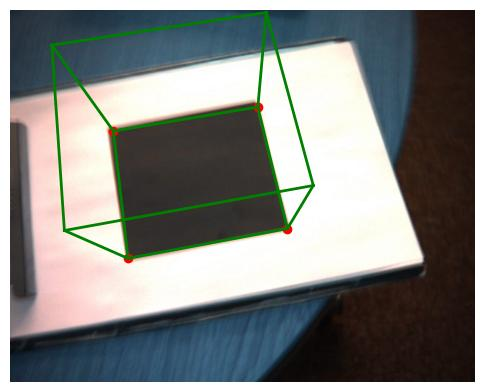

106


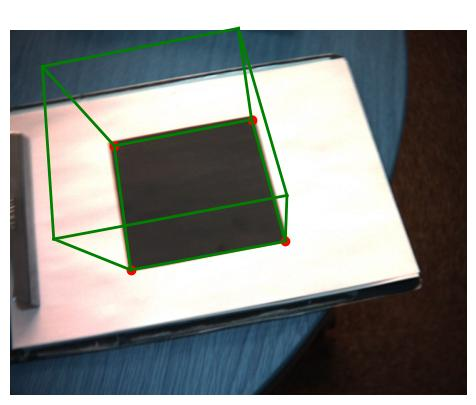

107


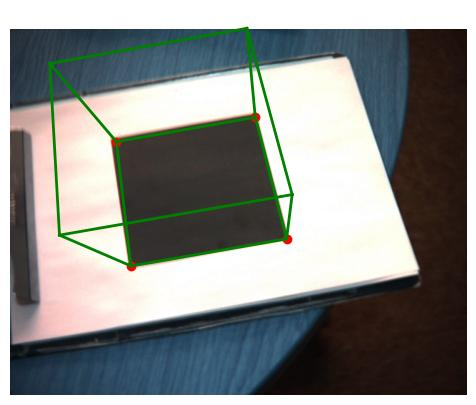

108


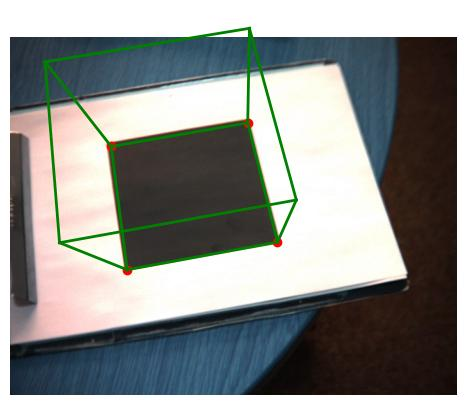

109


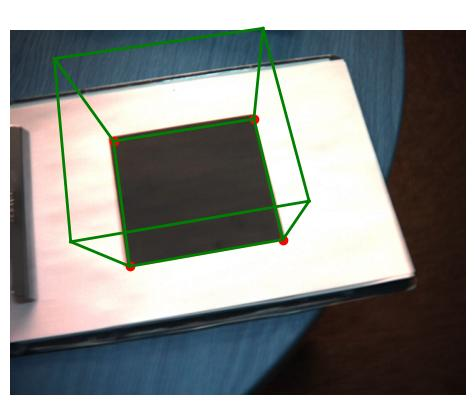

110


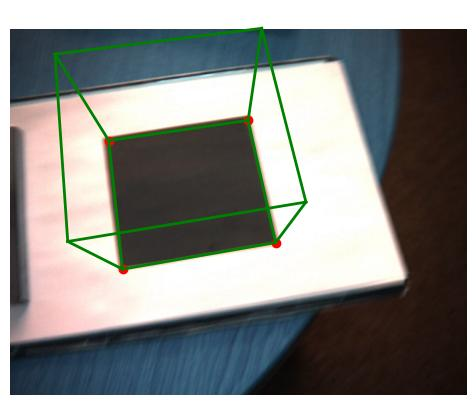

111


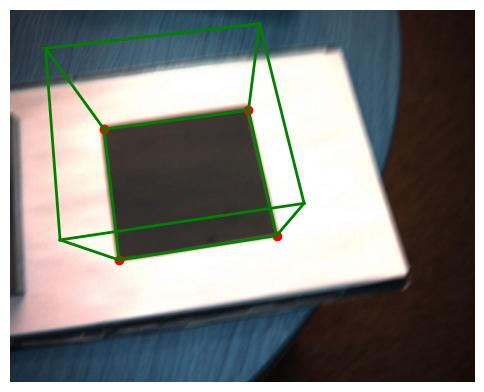

112


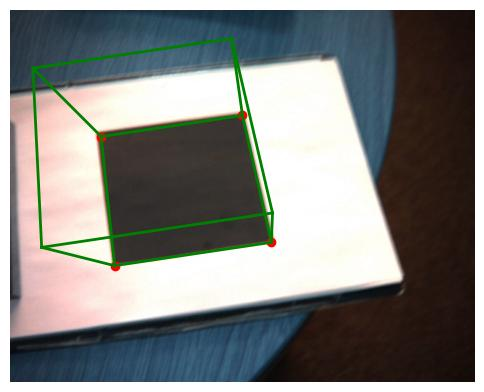

113


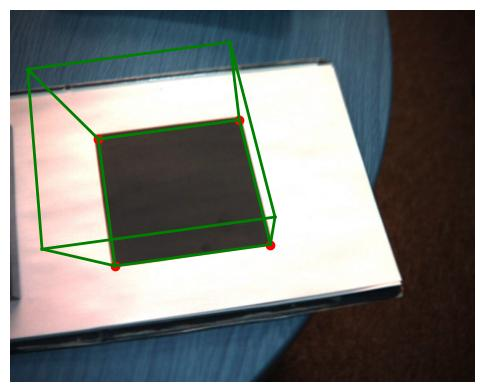

114


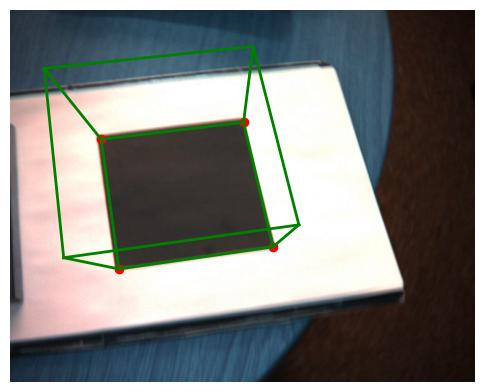

115


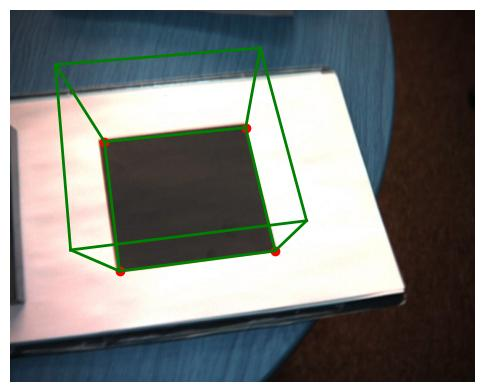

116


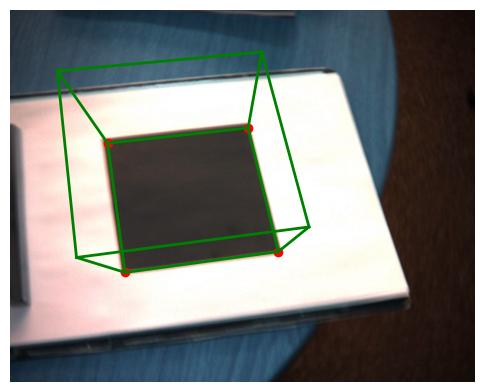

117


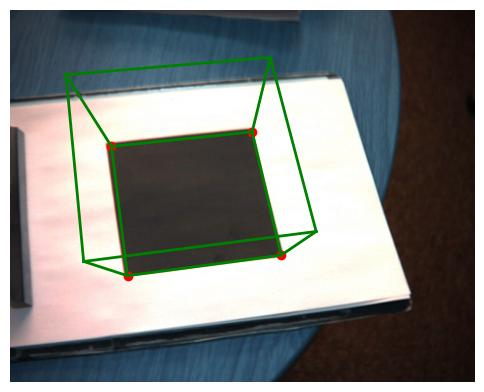

118


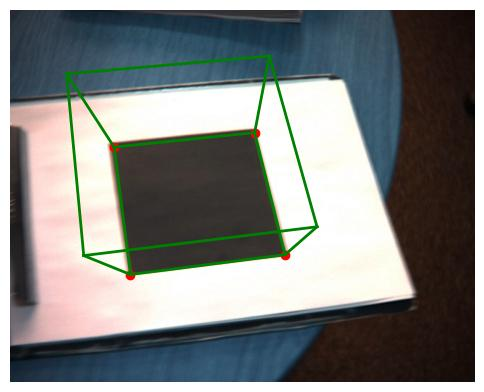

119


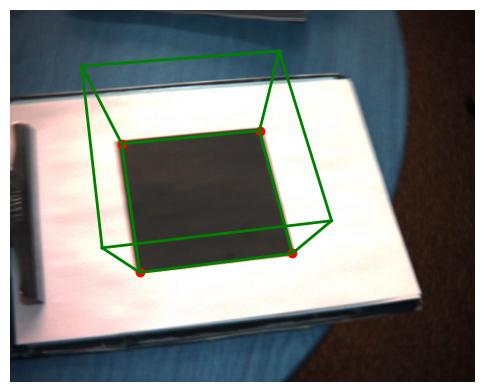

120


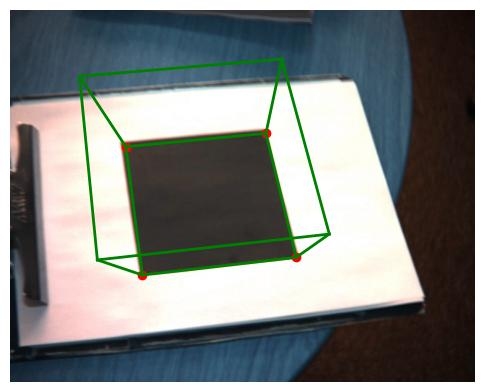

121


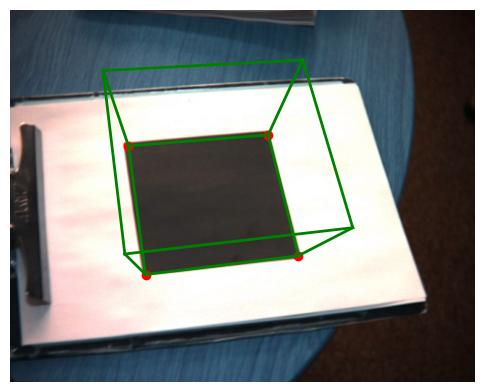

122


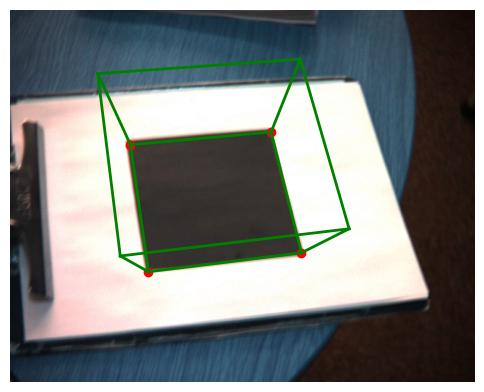

123


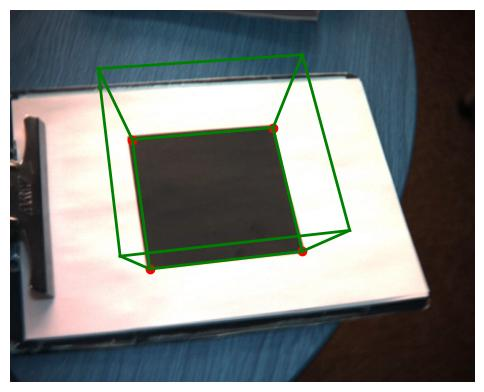

124


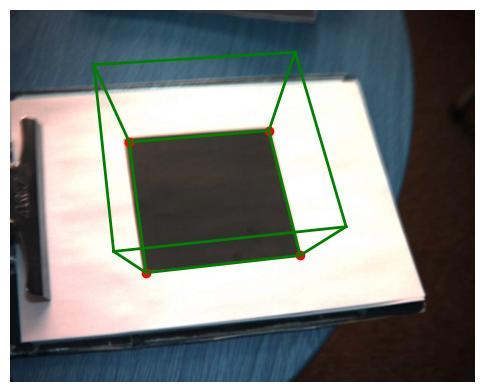

125


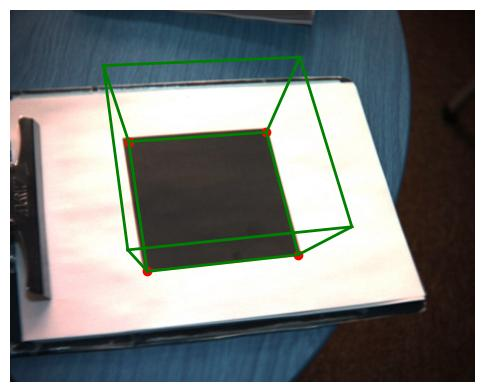

126


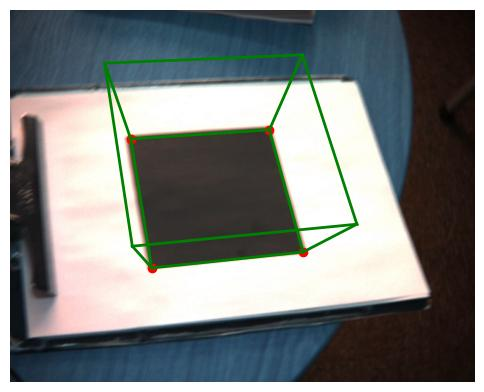

127


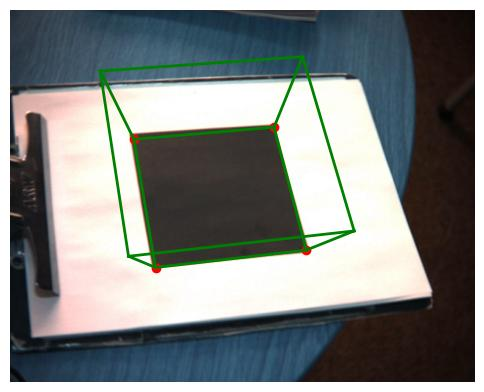

128


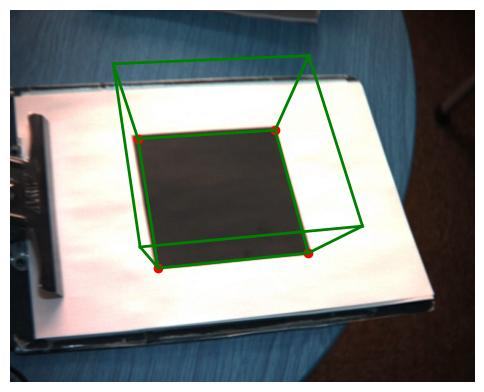

129


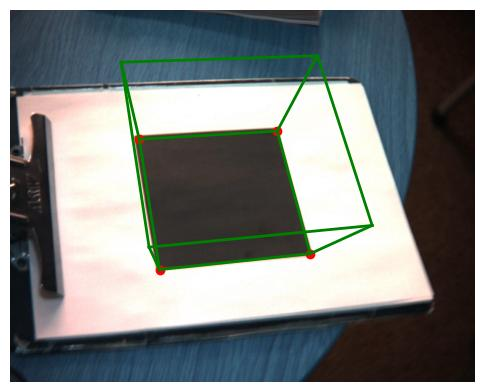

130


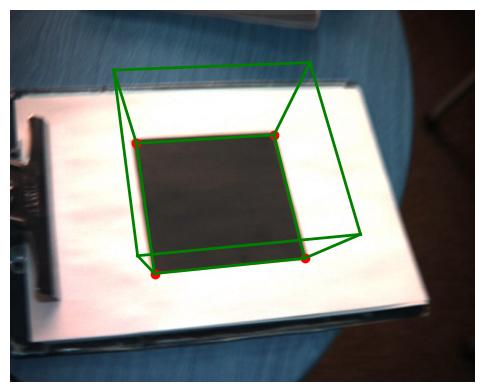

131


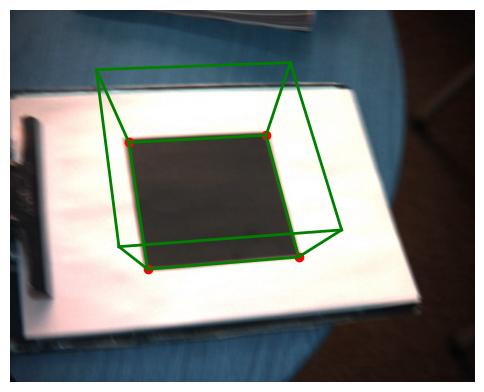

132


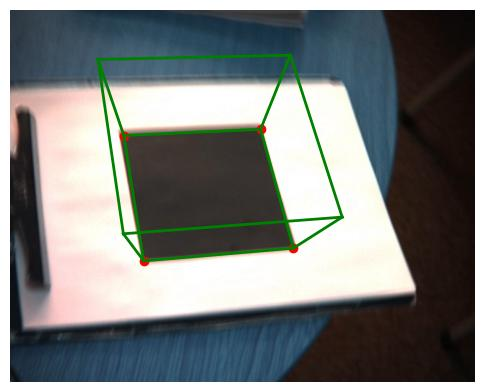

133


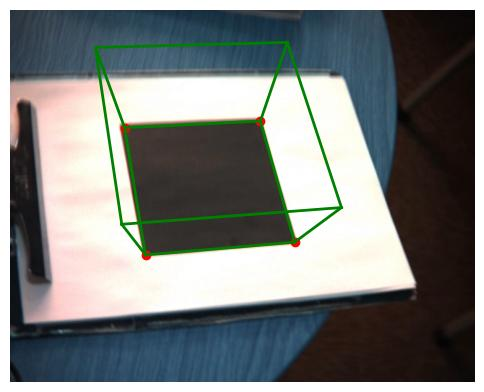

134


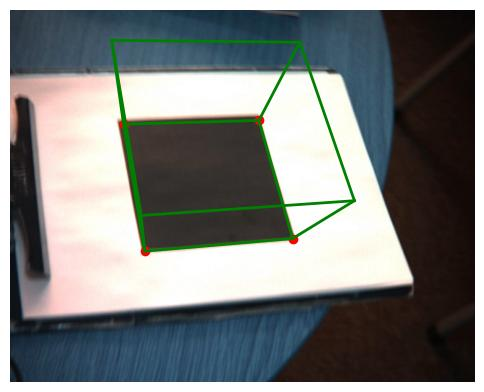

135


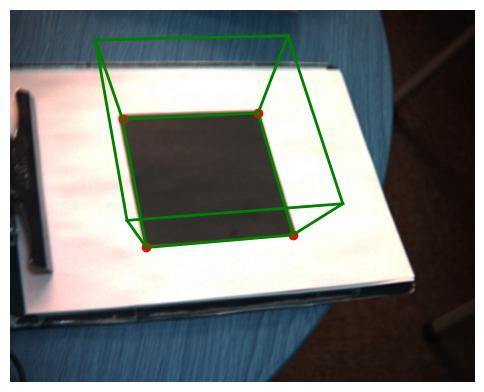

136


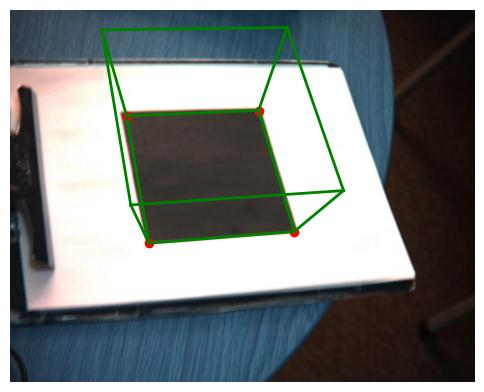

137


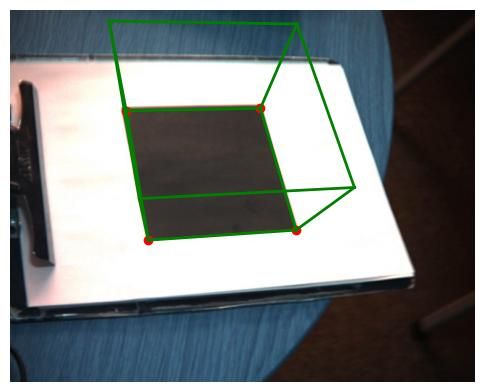

138


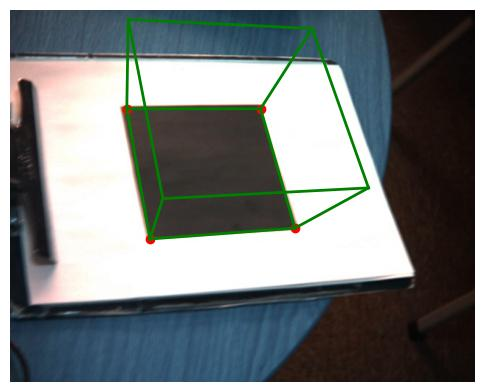

139


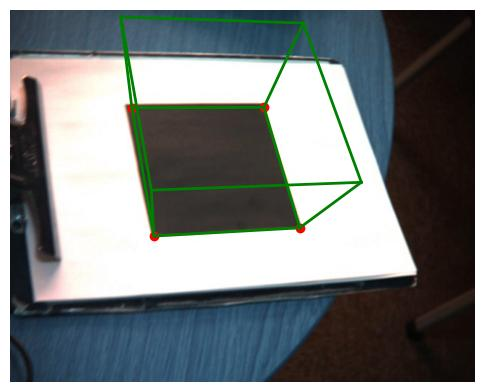

140


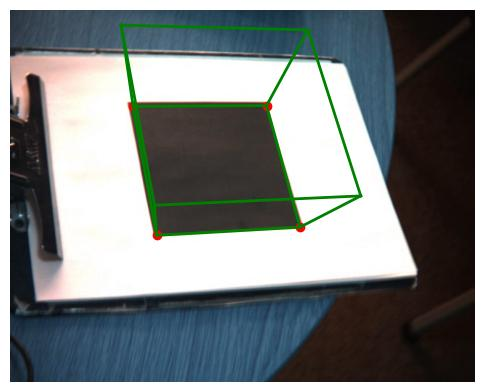

141


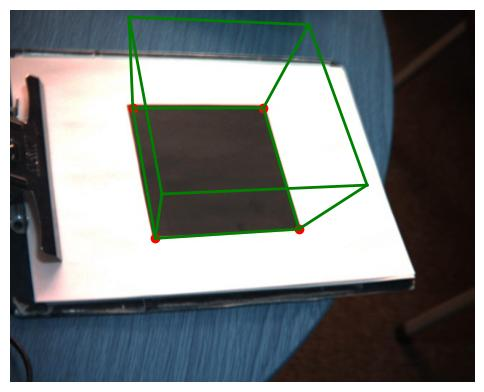

142


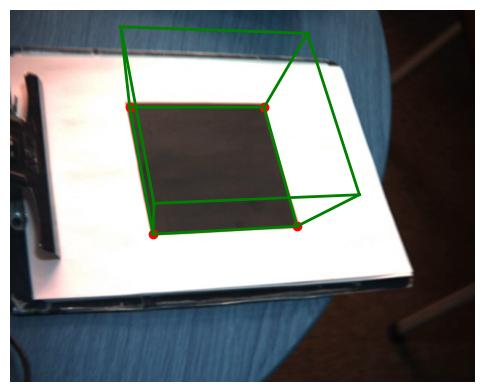

143


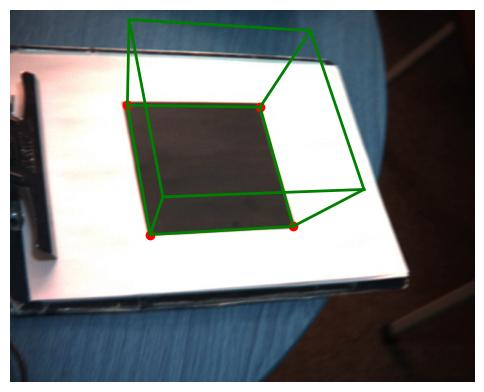

144


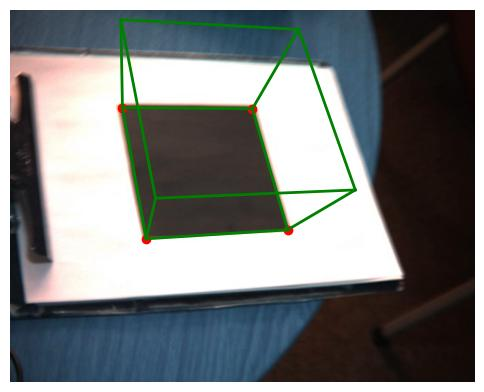

145


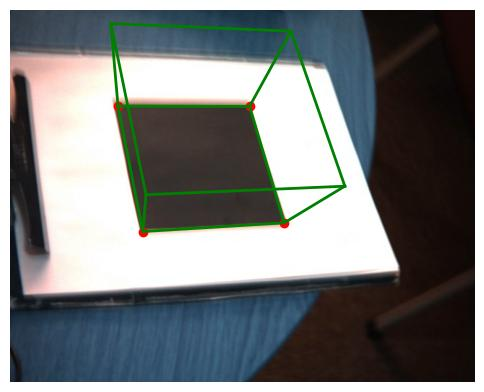

146


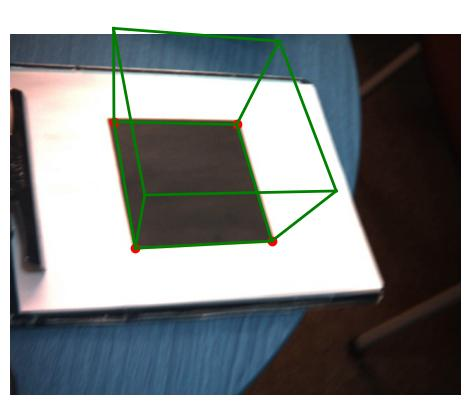

147


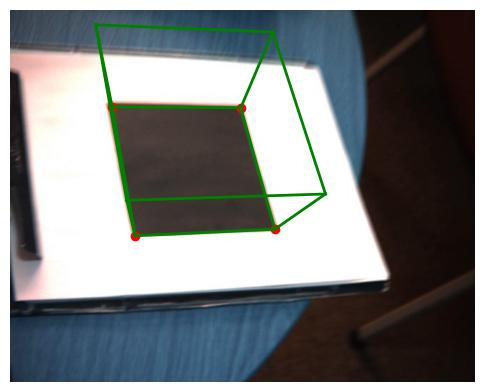

148


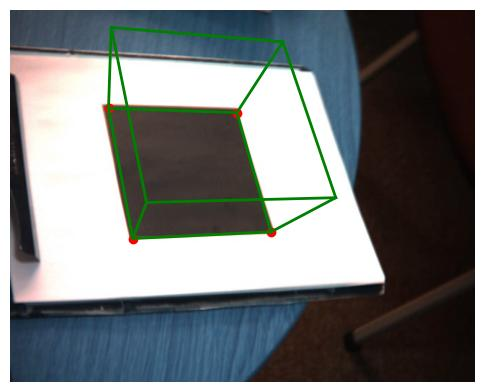

149


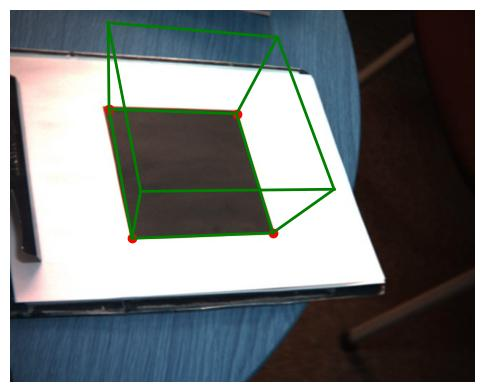

150


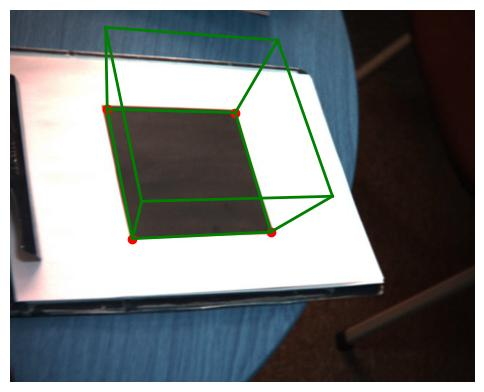

In [102]:
# ================================================
for iFrame in range(1, nFrame):
    
    print(iFrame)
    xImCart = np.array([LLs[iFrame,:].T, ULs[iFrame,:].T, URs[iFrame,:].T, LRs[iFrame,:].T]).T

    # get a frame from footage 
    im = images[iFrame]

    # Draw image and 2d points
    plt.imshow(im)
    plt.scatter(x = xImCart[0,:], y = xImCart[1,:],c = 'r')

    T = estimatePlanePose_Opt(xImCart, XCart, K);

    T_opt = minimize(error, T.reshape(16), args=xImCart).x.reshape(4, 4)
    XWireFrameCartProjected = projectiveCamera(K, T_opt, XWireFrameCart)
        
    for i in range(0, 4):
        x1 = XWireFrameCartProjected[0, i]
        y1 = XWireFrameCartProjected[1, i]
        if i + 1 < 4:
            x2 = XWireFrameCartProjected[0, i+1]
            y2 = XWireFrameCartProjected[1, i+1]
        else:
            x2 = XWireFrameCartProjected[0, 0]
            y2 = XWireFrameCartProjected[1, 0]
        plt.plot((x1, x2), (y1, y2), linewidth=2, color='green')

    for i in range(4, 8):
        x1 = XWireFrameCartProjected[0, i]
        y1 = XWireFrameCartProjected[1, i]
        if i + 1 < 8:
            x2 = XWireFrameCartProjected[0, i+1]
            y2 = XWireFrameCartProjected[1, i+1]
        else:
            x2 = XWireFrameCartProjected[0, 4]
            y2 = XWireFrameCartProjected[1, 4]
        plt.plot((x1, x2), (y1, y2), linewidth=2, color='green')

    for i in range(0, 4):
        x1 = XWireFrameCartProjected[0, i]
        y1 = XWireFrameCartProjected[1, i]
        x2 = XWireFrameCartProjected[0, i+4]
        y2 = XWireFrameCartProjected[1, i+4]
        plt.plot((x1, x2), (y1, y2), linewidth=2, color='green')
        
    plt.axis('off')
    plt.show()
